# Time Series - Clustering - Only Coefficients
Data Understanding and Preparation
- Explore and prepare the time series dataset.
- Preprocess the dataset in order to be able to run time series
clustering; motif/anomaly discovery and classification. If the dataset is
too big for these tasks, you can use approximations (e.g. SAX, PAA etc)

Motifs/Discords
- Analyze the dataset for finding motifs and/or anomalies. Visualize and
discuss them and their relationship with shapelets.

Clustering
- Use at least two clustering algorithm on time series using an
appropriate distance.
- Analyze the clusters and highlight similarities and differences and
visualize the clusters using at least 2 dimensionality reduction
techniques.

Classification
Define one (or more) classification task and solve it using:
- KNN with at least two distances
    - Euclidean/Manhattan
    - DTW
    - Shapelets
    - Analyze the shapelets retrieved
- At least one other method (rocket, muse, cnn, rnn etc)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
                            
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle
import random

from IPython.display import Audio 
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

### TS libraries

In [2]:
#Time Series Preprocessing
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#Distances
from scipy.spatial.distance import euclidean, cityblock
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#Time Series Approximation
from scipy.signal import decimate
from pyts.approximation import DiscreteFourierTransform, SymbolicAggregateApproximation
from sklearn.decomposition import TruncatedSVD, randomized_svd
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

#Time Series Clustering
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.pyplot import cm
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score,rand_score, adjusted_rand_score, mutual_info_score,\
                                adjusted_mutual_info_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from dtaidistance import dtw

#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
def imp_data(data_filename, data_npy, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    
    df_all = pd.concat([pd.read_csv(data_filename)['emotion'], pd.DataFrame(np.load(data_npy))], axis = 1)
    #df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = fraction, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    #scl_mv = TimeSeriesScalerMinMax() # mu=0., std=1.
    #X = scl_mv.fit_transform(X)
    #X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [4]:
def imp_for_centroids(data_filename, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = fraction, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    #scl_mv = TimeSeriesScalerMinMax(mu=0., std=1.)
    #X = scl_mv.fit_transform(X)
    #X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [5]:
def plot_eval_clust(km_labels, y_clust, X_clust, data_name = ''):
    if len(np.unique(km_labels)) == 3:
        emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']#['quiet','normal','loud']
    else:
        emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

    tab = pd.crosstab(km_labels,y_clust)
    tab = tab.div(tab.sum(1).astype(float), axis=0)
    tab.plot(kind='bar', stacked=True,color=['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], width = 0.8, figsize = (8,5))

    plt.xlabel('Cluster', fontsize = 15)
    plt.xticks(rotation=0, fontsize = 15)
    plt.yticks(rotation=0, fontsize = 15)
    plt.ylabel('Emotion (%)', fontsize = 15)
    #rotate x labels 90 degrees

    plt.legend(emotions,loc='upper left',bbox_to_anchor=(1, 1), fontsize = 15)
    plt.show()

    print()
    print()

    scores_dict = {}

    amis = adjusted_mutual_info_score(y_clust, km_labels)
    ars = adjusted_rand_score(y_clust, km_labels)
    fms = fowlkes_mallows_score(y_clust, km_labels)
    ss = silhouette_score(X_clust, km_labels)
    score_names = ['adjusted_mutual_info_score', 'adjusted_rand_score', 'fowlkes_mallows_score', 'silhouette_score'] # good 1, bad usually 0 or negative
    scores_km = [amis, ars, fms, ss]
    for i in range(len(scores_km)):
        print(f'{score_names[i].capitalize()} = {round(scores_km[i],3)}')
        scores_dict[score_names[i]+'_'+data_name.upper()] = scores_km[i]

    return scores_dict

In [6]:
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [7]:
def plot_pca_clust(X_clust, km_labels, name = ''):    
    n_com = 2
    pca = PCA(n_components=n_com)
    pca.fit(X_clust)
    principalComponents = pca.transform(X_clust)
    principalDf = pd.DataFrame(data = principalComponents
                        , columns = ['pc'+str(i) for i in range(1,n_com+1)])
    
    # Kmeans centroids
    centroids = []
    for i in range(0,8):
        centroids.append(np.mean(principalDf[km_labels == i], axis = 0))
    centroids = pd.DataFrame(centroids, columns = ['pc1', 'pc2'])
    
    if len(np.unique(km_labels)) == 8:
        plt.scatter(principalDf[km_labels==0]['pc1'],principalDf[km_labels==0]['pc2'], s = 60, edgecolor = 'grey', color = 'blue')
        plt.scatter(principalDf[km_labels==1]['pc1'],principalDf[km_labels==1]['pc2'], s = 60, edgecolor = 'grey', color = 'forestgreen')
        plt.scatter(principalDf[km_labels==2]['pc1'],principalDf[km_labels==2]['pc2'], s = 60, edgecolor = 'grey', color = 'deepskyblue')
        plt.scatter(principalDf[km_labels==3]['pc1'],principalDf[km_labels==3]['pc2'], s = 60, edgecolor = 'grey', color = 'salmon')
        plt.scatter(principalDf[km_labels==4]['pc1'],principalDf[km_labels==4]['pc2'], s = 60, edgecolor = 'grey', color = 'limegreen')
        plt.scatter(principalDf[km_labels==5]['pc1'],principalDf[km_labels==5]['pc2'], s = 60, edgecolor = 'grey', color = 'goldenrod')
        plt.scatter(principalDf[km_labels==6]['pc1'],principalDf[km_labels==6]['pc2'], s = 60, edgecolor = 'grey', color = 'crimson')
        plt.scatter(principalDf[km_labels==7]['pc1'],principalDf[km_labels==7]['pc2'], s = 60, edgecolor = 'grey', color = 'cyan')

        
        edgecolor = 'k'
        plt.scatter(centroids.loc[0,'pc1'],centroids.loc[0,'pc2'], label='Centroid Cluster 1\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='blue',      )
        plt.scatter(centroids.loc[1,'pc1'],centroids.loc[1,'pc2'], label='Centroid Cluster 2\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='forestgreen')
        plt.scatter(centroids.loc[2,'pc1'],centroids.loc[2,'pc2'], label='Centroid Cluster 3\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='deepskyblue')
        plt.scatter(centroids.loc[3,'pc1'],centroids.loc[3,'pc2'], label='Centroid Cluster 4\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='salmon',    )
        plt.scatter(centroids.loc[4,'pc1'],centroids.loc[4,'pc2'], label='Centroid Cluster 5\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='limegreen', )
        plt.scatter(centroids.loc[5,'pc1'],centroids.loc[5,'pc2'], label='Centroid Cluster 6\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='goldenrod', )
        plt.scatter(centroids.loc[6,'pc1'],centroids.loc[6,'pc2'], label='Centroid Cluster 7\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='crimson',   )
        plt.scatter(centroids.loc[7,'pc1'],centroids.loc[7,'pc2'], label='Centroid Cluster 8\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='cyan',      )

        plt.title(f'{name.upper()}')
        plt.legend()
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.xlabel('Principal Component 1', fontsize = 15)
        plt.ylabel('Principal Component 2', fontsize = 15)
        plt.show()
        plt.close()
    

    else:
        plt.scatter(principalDf[km_labels==0]['pc1'],principalDf[km_labels==0]['pc2'], s = 60, edgecolor = 'grey', color = 'blue')
        plt.scatter(principalDf[km_labels==1]['pc1'],principalDf[km_labels==1]['pc2'], s = 60, edgecolor = 'grey', color = 'forestgreen')
        plt.scatter(principalDf[km_labels==2]['pc1'],principalDf[km_labels==2]['pc2'], s = 60, edgecolor = 'grey', color = 'crimson')


        # Kmeans centroids
        centroids = []
        for i in range(0,3):
            centroids.append(np.mean(principalDf[km_labels == i], axis = 0))
        centroids = pd.DataFrame(centroids, columns = ['pc1', 'pc2'])
        edgecolor = 'k'
        plt.scatter(centroids.loc[0,'pc1'],centroids.loc[0,'pc2'], label='Centroid Cluster 1\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='blue',      )
        plt.scatter(centroids.loc[1,'pc1'],centroids.loc[1,'pc2'], label='Centroid Cluster 2\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='forestgreen')
        plt.scatter(centroids.loc[2,'pc1'],centroids.loc[2,'pc2'], label='Centroid Cluster 3\n', linewidth = 2, edgecolor = edgecolor, marker = 'X', s=400, c='crimson')

        plt.title(f'{name.upper()}')
        plt.legend()
        plt.yticks(fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.xlabel('Principal Component 1', fontsize = 15)
        plt.ylabel('Principal Component 2', fontsize = 15)
        plt.show()
        plt.close()

In [8]:
def dtw_and_matrix(X_clust):
    X_clust = np.squeeze(X_clust)
    distance_matrix = []
    m = len(X_clust)    
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            distance_matrix.append(dtw.distance_fast(X_clust[i].astype('double'), X_clust[j].astype('double')))
    
    distance_matrix = np.array(distance_matrix)
    d_mat = squareform(distance_matrix)

    return distance_matrix, d_mat
    

In [9]:
def plot_dendr(d, name = '', method = 'complete', color_threshold = 0):
    
    data_link = linkage(d, method = method)
    res = dendrogram(data_link, truncate_mode = 'lastp', color_threshold = color_threshold, above_threshold_color='k')
    plt.title(f'{method.capitalize()} Linkage {name.upper()}')
    #calculate Cophenetic Correlation Coefficient
    c, coph_dists = cophenet(data_link, d)
    print(f'Cophenetic Coefficient: {c}')

In [10]:
np.random.seed(42)  # for reproducibility

## K-Means on coefficients (euclidean)

In [12]:
results = {}

In [13]:
fraction = 0.5
n_clusters = 8
metric = 'euclidean'

### SAX

In [14]:
X_clust_sax, y_clust_sax, df_sax = imp_data('data_ts\data_100_sax.csv', 'data_ts\\ts_100_sax.npy', fraction = fraction, emotions = n_clusters)
print(df_sax.shape)
df_sax.head()

(914, 151)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,3,49,49,49,49,49,50,50,50,50,50,47,49,50,50,50,49,52,51,51,49,45,44,45,46,49,52,52,50,50,52,53,50,49,47,46,51,55,54,57,55,31,35,48,65,65,53,55,45,46,45,49,42,38,46,56,48,49,50,60,61,32,29,51,52,65,56,60,43,48,48,50,47,45,44,51,45,51,47,88,92,2,0,90,73,52,71,71,55,37,46,51,49,66,65,45,53,41,15,23,61,76,57,59,53,51,43,41,37,41,50,58,55,54,51,50,47,48,51,48,51,56,53,40,48,58,49,32,22,27,61,66,61,75,69,54,45,40,47,49,47,50,51,48,46,48,49,49,52,48,44
1,7,49,50,49,49,47,52,52,47,52,47,51,47,51,51,46,50,54,49,47,48,51,50,50,49,49,50,49,50,50,49,49,49,49,48,54,45,54,48,51,49,47,50,48,50,49,50,49,50,49,49,49,49,50,50,50,49,49,49,50,50,49,50,49,50,51,49,48,49,50,49,49,51,47,53,48,47,56,43,48,52,55,53,37,56,47,53,49,49,47,47,51,53,50,46,50,50,48,51,50,50,48,53,47,52,46,54,45,50,50,50,49,50,49,50,49,50,51,48,51,48,51,49,46,53,51,48,52,47,46,49,52,53,48,50,49,51,48,50,48,48,52,47,54,50,46,51,50,49,49,50
2,3,50,50,49,50,50,50,50,50,50,49,50,49,50,49,50,51,51,47,51,50,47,49,52,51,46,49,51,50,48,51,49,48,49,53,47,48,53,46,52,48,51,49,47,52,50,49,50,49,50,49,49,50,49,50,49,49,51,50,49,48,48,50,50,50,49,50,50,49,50,52,49,47,50,52,45,54,45,50,49,51,52,49,50,49,47,48,51,49,50,50,49,51,48,49,51,48,51,47,50,52,50,47,49,54,47,49,50,48,54,44,52,51,48,50,50,50,52,46,48,53,51,46,51,51,46,50,51,50,50,48,48,53,46,53,49,46,53,50,47,51,51,49,49,49,50,50,49,49,49,49
3,3,50,49,50,49,50,50,50,50,49,50,51,47,46,50,51,50,51,51,46,50,53,44,53,48,51,50,48,49,50,50,49,50,50,50,49,50,50,44,55,50,50,49,49,49,49,50,50,49,49,50,50,49,49,49,51,48,49,47,51,52,49,49,50,49,48,52,46,57,42,56,43,56,42,58,41,56,46,51,49,50,47,54,50,50,47,50,49,52,50,48,50,51,45,51,48,51,49,49,50,50,50,47,51,49,49,50,50,49,50,50,49,50,50,49,49,51,47,50,51,49,49,53,49,48,48,48,49,52,50,48,51,48,48,50,50,50,50,50,49,49,49,50,49,49,50,50,50,49,50,50
4,3,48,50,51,49,49,51,51,50,47,47,49,49,51,51,50,47,49,47,46,49,60,48,49,53,55,43,44,55,52,43,53,51,51,58,41,44,43,50,52,51,48,49,58,46,46,48,49,50,50,49,49,49,48,48,49,54,44,58,49,50,48,49,48,50,52,51,55,43,52,48,46,51,45,53,53,49,51,49,46,47,49,60,51,42,37,45,49,50,53,56,55,52,55,51,52,43,41,50,50,49,49,52,51,43,49,49,52,49,54,49,53,50,49,48,49,51,45,52,52,51,51,48,49,52,47,46,53,49,47,52,53,46,53,49,50,48,47,49,50,51,49,48,47,47,49,52,51,51,50,51


In [15]:
print('____________________SAX____________________')
print()

# computing kMeans
kmeans_sax = KMeans(n_clusters=n_clusters, #metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_sax.fit(X_clust_sax)

____________________SAX____________________



c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(max_iter=50, random_state=100)

Centroids' shape (8, 150)

KMeans assigned labels:
 [0 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3
 3 3 3 4 3 3 4 3 3 3 3 3 3 3 0 4 0 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 0 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 0 3 3 3 3 3 3 3 0 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 0 3 3 3 3 3 3
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

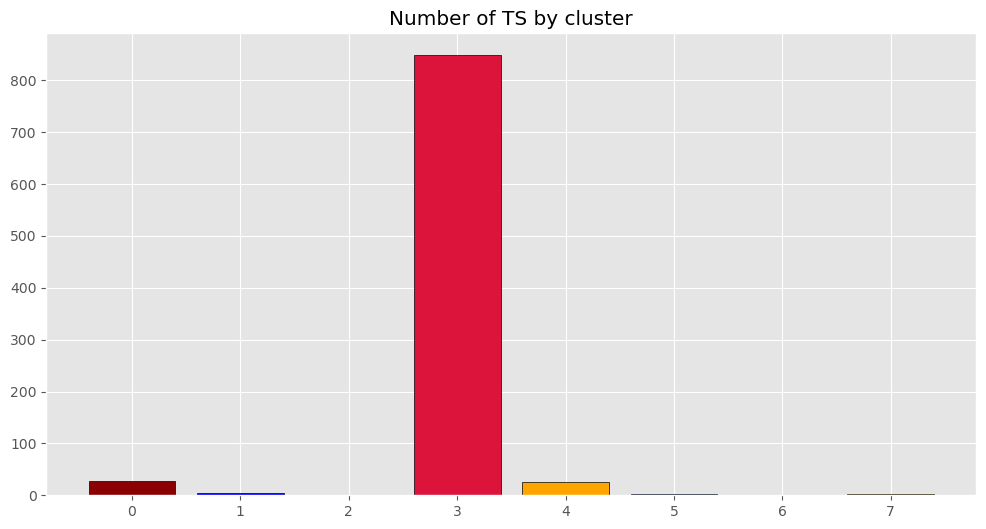


KMeans inertia:  2793078.175038876



In [16]:
# centroids
centroids_sax = kmeans_sax.cluster_centers_
print('Centroids\' shape',centroids_sax.shape)
print()

# inverse transform
#df_centroids_sax = dft_inverse_trasform(np.squeeze(centroids_sax), n_coefs=centroids_sax.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_sax)):
#    c = np.array(df_centroids_sax[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_sax = kmeans_sax.labels_
print('KMeans assigned labels:\n',km_labels_sax)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_sax, return_counts=True)[0], np.unique(km_labels_sax, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_sax = kmeans_sax.inertia_
print('KMeans inertia: ', inertia_sax)
print()

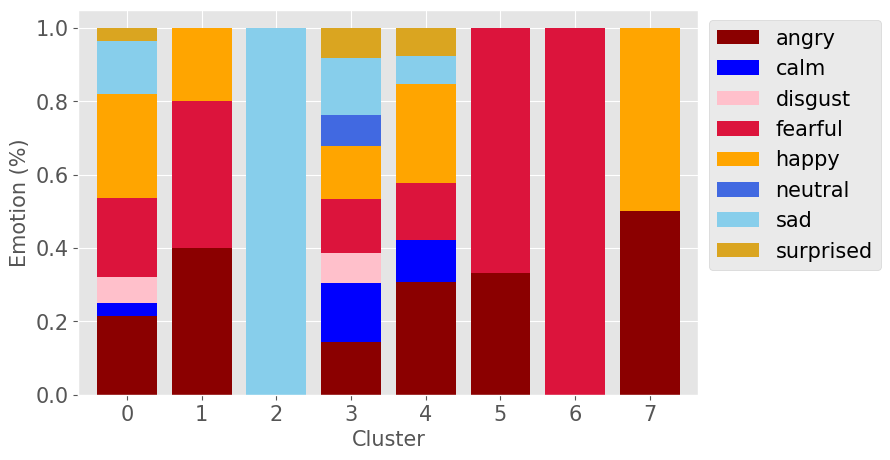



Adjusted_mutual_info_score = 0.006
Adjusted_rand_score = -0.003
Fowlkes_mallows_score = 0.337
Silhouette_score = 0.472


In [17]:
# emotions' distribution within different clusters and evaluation measures
res_km_sax = plot_eval_clust(km_labels_sax, y_clust_sax, X_clust_sax, 'km_sax')
results['km_sax'] = res_km_sax

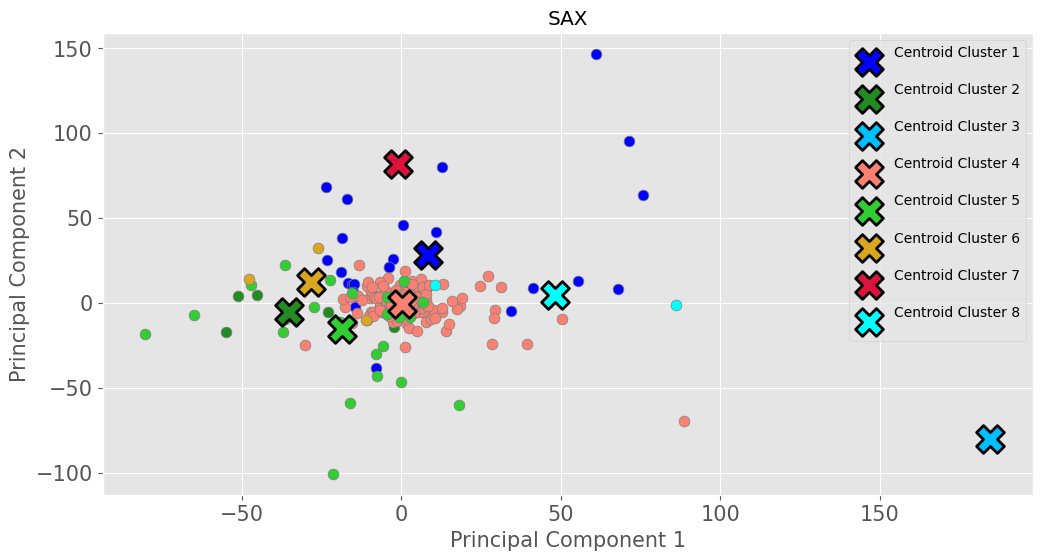

In [18]:
plot_pca_clust(X_clust_sax,km_labels_sax,name='sax')

### PAA

In [19]:
X_clust_paa, y_clust_paa, df_paa = imp_data('data_ts\data_150_paa.csv', 'data_ts\\ts_150_paa.npy', fraction = fraction, emotions = n_clusters)
print(df_paa.shape)
df_paa.head()

(914, 151)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,3,-0.009181,-0.016150,-0.016126,-0.014893,-0.008963,0.011608,0.003789,0.003940,0.016012,0.023392,-0.060181,-0.003097,0.002169,0.016444,0.005731,-0.000677,0.059279,0.048124,0.040465,-0.018534,-0.100695,-0.127685,-0.102069,-0.084384,-0.022782,0.071309,0.059959,0.005776,0.022119,0.062967,0.075870,0.017583,-0.017181,-0.071922,-0.076734,0.032331,0.128760,0.113043,0.180157,0.137507,-0.470873,-0.380577,-0.026346,0.392899,0.401951,0.076984,0.136498,-0.108442,-0.090416,-0.118262,-0.011479,-0.189899,-0.282588,-0.090958,0.154127,-0.043037,-0.014728,0.015821,0.275675,0.294562,-0.444604,-0.533831,0.035126,0.059061,0.400995,0.163534,0.263472,-0.161540,-0.042200,-0.032197,0.015243,-0.074993,-0.122540,-0.141110,0.030689,-0.104581,0.042415,-0.068658,1.182612,1.421571,-2.024449,-3.038951,1.294782,0.632665,0.064779,0.559874,0.559803,0.135136,-0.329484,-0.090836,0.042806,-0.005502,0.438894,0.391988,-0.120484,0.097992,-0.225734,-1.036428,-0.711586,0.295095,0.735590,0.195758,0.232458,0.093032,0.042720,-0.165544,-0.209217,-0.307417,-0.208058,0.022474,0.204634,0.132500,0.121670,0.039612,0.018398,-0.052672,-0.035303,0.048651,-0.029836,0.050040,0.158913,0.099126,-0.239710,-0.032043,0.218214,-0.008008,-0.465661,-0.765783,-0.606688,0.286101,0.438029,0.287226,0.696031,0.506319,0.120113,-0.123157,-0.230482,-0.063030,-0.022609,-0.072083,0.011990,0.032853,-0.041041,-0.088678,-0.027405,-0.021444,-0.001591,0.070307,-0.028815,-0.143300
1,7,-0.001226,0.003587,-0.001840,-0.006128,-0.065937,0.054373,0.057225,-0.051017,0.057126,-0.072129,0.042344,-0.054929,0.033545,0.048677,-0.083447,0.003692,0.103703,-0.014005,-0.055098,-0.031844,0.031112,0.001051,0.002603,-0.004638,-0.003317,0.011613,-0.004529,0.004937,0.002986,-0.002536,-0.000582,-0.001844,-0.001219,-0.049509,0.113021,-0.112813,0.109863,-0.042049,0.044627,-0.015676,-0.058667,0.022579,-0.031786,0.016330,-0.003636,0.017072,-0.001356,0.000200,-0.004233,-0.004186,-0.003088,-0.000082,0.000492,0.001250,0.000918,-0.001178,-0.000510,-0.000039,0.000337,0.001037,-0.002014,0.000121,-0.000002,0.015023,0.040977,-0.006506,-0.045935,-0.000467,0.004655,-0.019910,-0.002744,0.043379,-0.052195,0.085761,-0.050011,-0.069135,0.154545,-0.166782,-0.040828,0.066081,0.150639,0.084706,-0.315889,0.169248,-0.071131,0.094795,-0.011370,-0.015836,-0.050227,-0.060868,0.047199,0.079275,0.007388,-0.079043,0.005166,0.012579,-0.036428,0.025076,0.004922,0.021061,-0.028528,0.085053,-0.073105,0.050316,-0.089959,0.116045,-0.112405,0.017558,0.007596,0.016327,-0.009240,0.016603,-0.019818,0.013902,-0.014535,0.005640,0.029397,-0.043229,0.042032,-0.030605,0.025870,-0.003240,-0.097644,0.085211,0.034570,-0.036808,0.061845,-0.060060,-0.083276,-0.005635,0.066253,0.091865,-0.047010,0.003694,-0.023523,0.025376,-0.035490,0.016282,-0.032863,-0.029694,0.059571,-0.065849,0.102110,0.000797,-0.084646,0.033873,0.004640,-0.005309,-0.000410,0.003950
2,3,0.000705,0.000728,-0.000534,0.000760,0.000117,0.000208,0.000548,0.000024,0.000048,-0.004080,0.003529,-0.001058,0.000312,-0.001539,0.001127,0.025558,0.025793,-0.060876,0.026410,0.005488,-0.065471,-0.005250,0.069994,0.043882,-0.077197,-0.020767,0.036196,0.009938,-0.039228,0.049776,-0.004776,-0.033909,-0.007320,0.081041,-0.052247,-0.050109,0.098424,-0.084547,0.050821,-0.042658,0.045389,-0.009888,-0.064509,0.058262,0.019916,-0.025032,0.001978,-0.002820,0.000457,-0.001738,-0.003935,0.001851,-0.000811,0.003331,-0.014817,-0.009172,0.035593,0.023997,-0.002839,-0.034767,-0.039047,0.013955,0.014893,0.013075,-0.007464,0.005100,0.002026,-0.002

In [20]:
print('____________________PAA____________________')
print()

# computing kMeans
kmeans_paa = KMeans(n_clusters=n_clusters, #metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_paa.fit(X_clust_paa)

____________________PAA____________________



c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(max_iter=50, random_state=100)

Centroids' shape (8, 150)

KMeans assigned labels:
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 2 3 3 3
 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

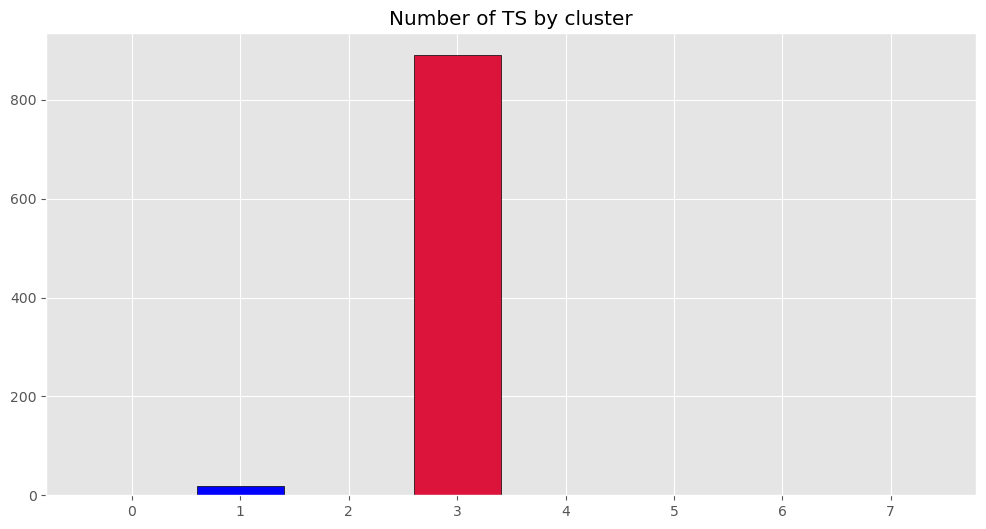


KMeans inertia:  2813.0242798278564



In [21]:
# centroids
centroids_paa = kmeans_paa.cluster_centers_
print('Centroids\' shape',centroids_paa.shape)
print()

# inverse transform
#df_centroids_paa = dft_inverse_trasform(np.squeeze(centroids_paa), n_coefs=centroids_paa.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_paa)):
#    c = np.array(df_centroids_paa[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_paa = kmeans_paa.labels_
print('KMeans assigned labels:\n',km_labels_paa)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_paa, return_counts=True)[0], np.unique(km_labels_paa, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_paa = kmeans_paa.inertia_
print('KMeans inertia: ', inertia_paa)
print()

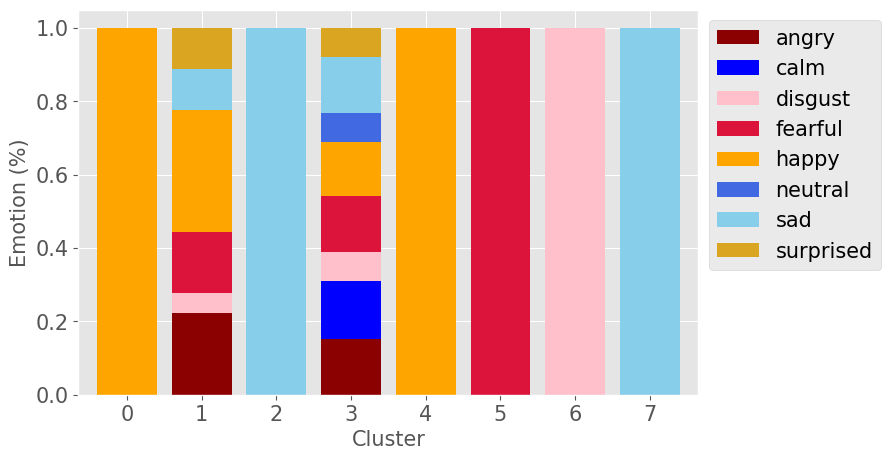



Adjusted_mutual_info_score = 0.002
Adjusted_rand_score = -0.001
Fowlkes_mallows_score = 0.357
Silhouette_score = 0.695


In [22]:
# emotions' distribution within different clusters and evaluation measures
res_km_paa = plot_eval_clust(km_labels_paa, y_clust_paa, X_clust_paa, 'km_paa')
results['km_paa'] = res_km_paa

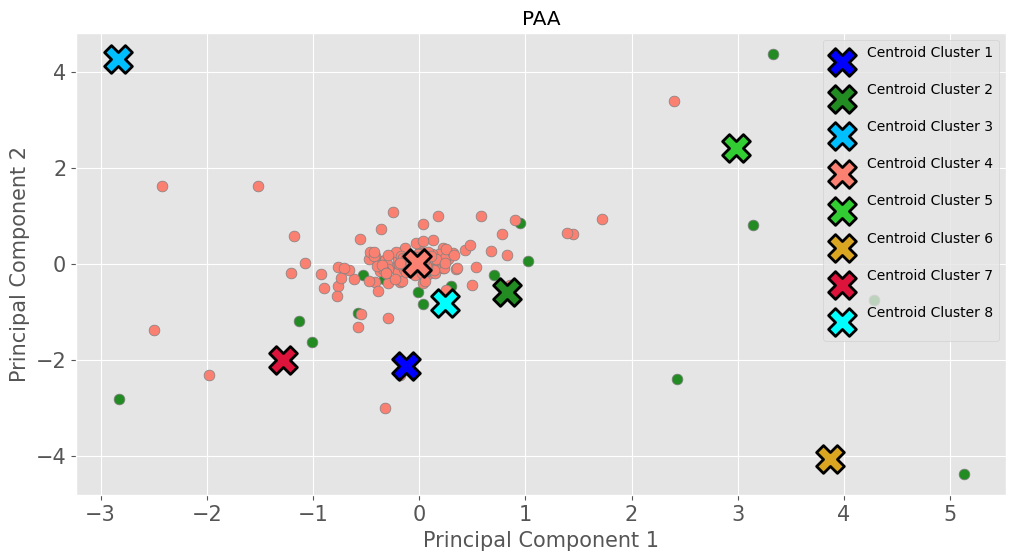

In [23]:
plot_pca_clust(X_clust_paa,km_labels_paa,'paa')

### DFT

In [24]:
X_clust_dft, y_clust_dft, df_dft = imp_data('data_ts\data_150_dft.csv', 'data_ts\\ts_150_dft.npy', fraction = fraction, emotions = n_clusters)
print(df_dft.shape)
df_dft.head()

(914, 151)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,3,-3.552714e-15,-1.244801,4.281954,-0.807810,-1.163216,-5.545275,23.628888,-10.409080,6.678316,-1.730009,-12.666532,-71.053544,-1.772132,20.480025,-65.292471,1.850320,-7.209136,42.941550,-24.255274,103.791756,87.141946,-71.197834,30.981585,-8.139965,-5.438237,-67.760147,75.235760,-56.344621,-122.097086,-86.767906,-38.037998,231.438911,-27.863325,-46.912892,106.896371,27.118223,-130.751561,58.435291,214.933950,-157.573024,-34.708521,94.151342,-25.050411,-201.857656,-42.076550,137.379564,23.580357,-32.017678,-44.590714,109.151165,16.459915,-162.706731,44.517936,97.419009,-55.915444,-59.532145,80.900149,-18.173337,-174.347044,47.813603,152.579586,34.516521,-96.145958,-62.025211,132.155461,-59.598348,-134.853651,64.648671,113.113245,-115.529241,-153.163045,210.632514,19.877050,-173.815539,27.063151,185.278240,18.402829,-157.880975,32.713736,76.348999,-52.406240,-112.369171,79.476529,102.405841,-151.987112,-56.863429,160.146102,-39.819477,-199.258345,98.209790,175.288349,-88.198668,-119.723271,95.469286,66.840337,-112.957049,-19.830752,82.054535,-1.517874,-93.084989,-23.726990,107.662426,-48.326756,-73.792066,53.502599,106.452107,-47.970574,-58.669040,84.580349,3.327019,-65.871774,-7.396592,61.484007,-29.438510,-69.667826,36.699197,30.910332,-30.300942,-53.891560,59.865422,45.044396,-45.776898,-22.305228,42.857097,6.487027,-40.004937,24.564832,19.926309,-38.047790,-13.596297,33.830259,1.061156,-41.372031,9.345972,25.072535,-1.921036,-23.028645,15.938602,14.161302,-18.562355,1.786729,17.496918,-3.629578,-24.825106,8.696473,16.128464,-26.376766,-1.404140,23.433830,-13.844991
1,7,2.486900e-14,-0.086931,0.001168,0.019269,-0.111728,-0.154932,-0.175524,0.149490,-0.013097,0.057148,-0.061236,-0.160364,0.043080,-0.006654,-0.006218,-0.039257,-0.003458,-0.117480,-0.029184,0.140665,-0.004047,-0.265123,-0.034318,0.033966,0.270719,-0.043717,-0.057609,0.033723,-0.393054,-0.573894,0.041198,0.497978,0.631271,0.480242,-0.564272,-0.340959,-0.105818,-0.463398,0.266421,0.253989,0.176766,0.111958,-0.367461,-0.246232,-0.210274,0.290113,0.274498,-0.155398,0.059344,-0.234080,-0.265799,0.230490,-0.116034,0.158155,0.138759,-0.269824,-0.050520,-0.252952,-0.155495,0.062679,-0.061722,-0.161332,-0.528913,-0.370408,-0.569472,0.431607,-0.211382,0.591574,0.194822,-0.081482,0.033409,-0.376848,-0.073913,0.016296,0.012084,0.133144,-0.145600,-0.141037,-0.136452,0.107071,0.074344,0.048903,0.144023,0.350732,-0.039818,-0.243014,0.303438,-0.367956,0.008260,-0.135122,-0.119798,-0.031984,-0.184532,-0.105826,0.258917,-0.223803,-0.166749,0.290299,0.137587,-0.143522,0.165928,-0.051241,0.509289,-0.285762,-0.293787,-0.059770,-0.502268,0.366687,-0.115740,-0.081989,1.183692,-0.494321,0.011307,0.072915,-0.193084,0.508300,-0.044178,-0.191730,0.540129,-0.215532,-0.078008,0.152984,-0.367488,0.371348,0.144235,0.740634,0.806800,-0.429511,0.468597,-1.338867,0.735900,-0.224072,-1.159643,0.152808,-0.513081,0.542017,0.578501,-0.487986,0.263743,0.405479,-0.712981,-0.263647,0.706281,-0.305190,0.449715,-0.646446,-0.655424,0.301265,0.847290,0.487739
2,3,2.753353e-14,0.001319,-0.014132,0.020050,-0.048667,-0.012637,-0.001244,-0.068451,-0.015282,0.129840,0.014548,-0.025528,-0.016966,0.008186,-0.008028,0.068521,-0.039699,-0.196818,0.012568,-0.046555,-0.138825,0.070894,-0.118412,-0.070379,-0.042024,-0.000923,0.029197,-0.055185,-0.087135,-0.100245,-0.152741,-0.155264,-0.028146,0.079822,0.360393,0.352865,-0.263294,0.082526,0.230862,-0.187007,0.070421,0.364953,-0.575951,-0.157103,-0.033795,-0.453600,-0.067945,0.

In [25]:
print('____________________DFT____________________')
print()

# computing kMeans
kmeans_dft = KMeans(n_clusters=n_clusters, #metric=metric, #dtw, softdtw
                      max_iter=50, init='k-means++', random_state=100)
kmeans_dft.fit(X_clust_dft)

____________________DFT____________________



c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(max_iter=50, random_state=100)

Centroids' shape (8, 150)

KMeans assigned labels:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

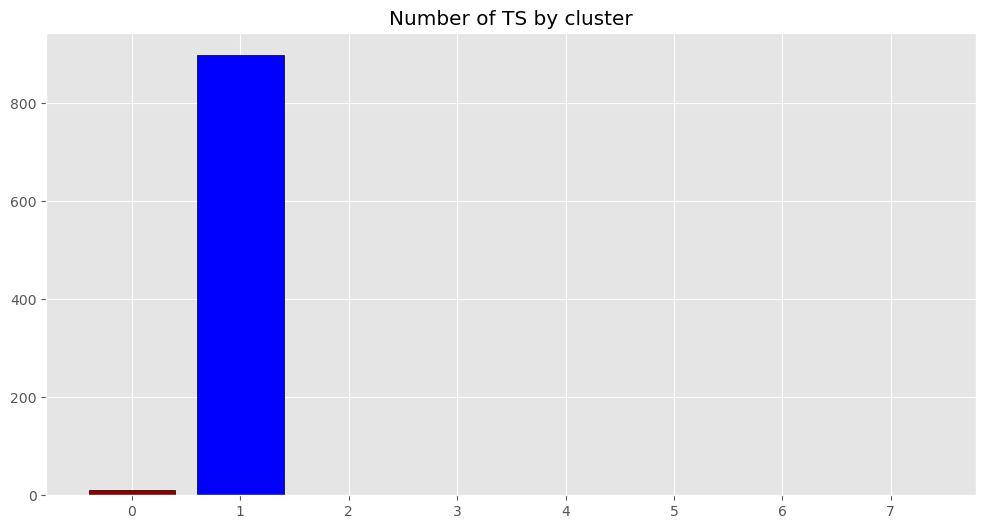


KMeans inertia:  72882899.21219634



In [26]:
# centroids
centroids_dft = kmeans_dft.cluster_centers_
print('Centroids\' shape',centroids_dft.shape)
print()

# inverse transform
#df_centroids_dft = dft_inverse_trasform(np.squeeze(centroids_dft), n_coefs=centroids_dft.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_dft)):
#    c = np.array(df_centroids_dft[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_dft = kmeans_dft.labels_
print('KMeans assigned labels:\n',km_labels_dft)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_dft, return_counts=True)[0], np.unique(km_labels_dft, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_dft = kmeans_dft.inertia_
print('KMeans inertia: ', inertia_dft)
print()

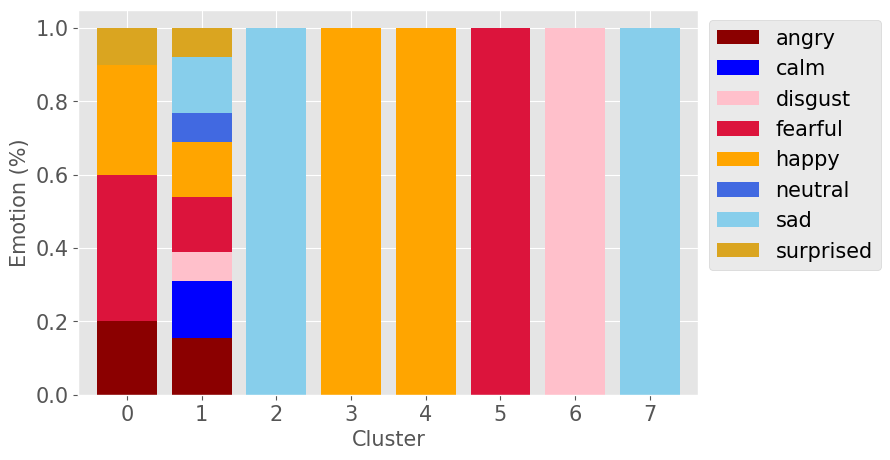



Adjusted_mutual_info_score = 0.002
Adjusted_rand_score = -0.001
Fowlkes_mallows_score = 0.36
Silhouette_score = 0.8


In [27]:
# emotions' distribution within different clusters and evaluation measures
res_km_dft = plot_eval_clust(km_labels_dft, y_clust_dft, X_clust_dft, 'km_dft')
results['km_dft'] = res_km_dft

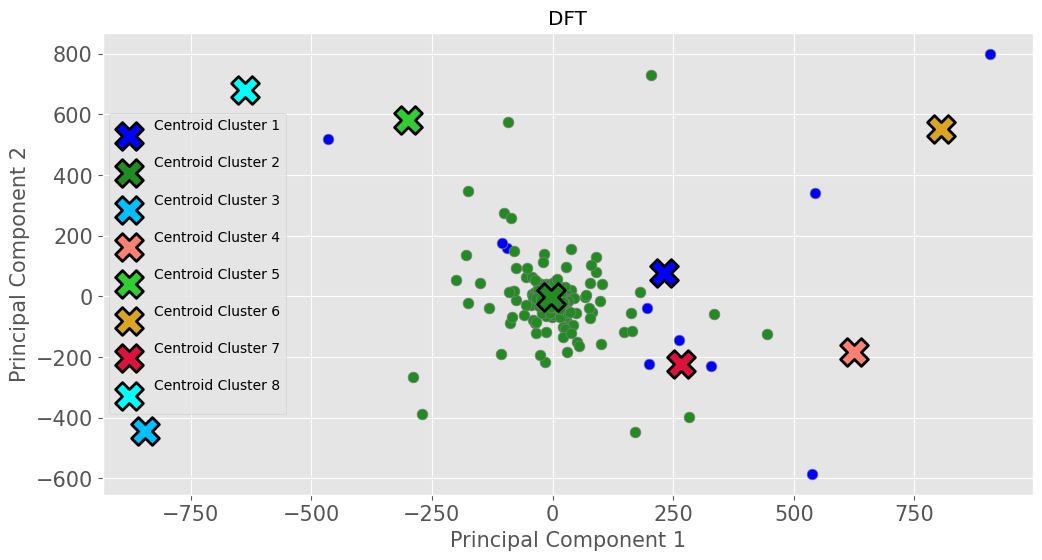

In [28]:
plot_pca_clust(X_clust_dft,km_labels_dft,'dft')

In [29]:
print('EUCLIDEAN')
pd.DataFrame(results.values()).T

EUCLIDEAN


,0,1,2
adjusted_mutual_info_score_KM_SAX,0.006233,NaN,NaN
adjusted_rand_score_KM_SAX,-0.003467,NaN,NaN
fowlkes_mallows_score_KM_SAX,0.336870,NaN,NaN
silhouette_score_KM_SAX,0.472346,NaN,NaN
adjusted_mutual_info_score_KM_PAA,NaN,0.001982,NaN
adjusted_rand_score_KM_PAA,NaN,-0.000565,NaN
fowlkes_mallows_score_KM_PAA,NaN,0.356707,NaN
silhouette_score_KM_PAA,NaN,0.694954,NaN
adjusted_mutual_info_score_KM_DFT,NaN,NaN,0.002368
adjusted_rand_score_KM_DFT,NaN,NaN,-0.000636


## K-Means on coefficients (DTW)

In [30]:
results = {}

In [31]:
n_clusters = 8
metric = 'dtw'

### SAX

In [32]:
X_clust_sax, y_clust_sax, df_sax = imp_data('data_ts\data_100_sax.csv', 'data_ts\\ts_100_sax.npy', fraction = fraction, emotions = n_clusters)
print(df_sax.shape)
df_sax.head()

(914, 151)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,3,49,49,49,49,49,50,50,50,50,50,47,49,50,50,50,49,52,51,51,49,45,44,45,46,49,52,52,50,50,52,53,50,49,47,46,51,55,54,57,55,31,35,48,65,65,53,55,45,46,45,49,42,38,46,56,48,49,50,60,61,32,29,51,52,65,56,60,43,48,48,50,47,45,44,51,45,51,47,88,92,2,0,90,73,52,71,71,55,37,46,51,49,66,65,45,53,41,15,23,61,76,57,59,53,51,43,41,37,41,50,58,55,54,51,50,47,48,51,48,51,56,53,40,48,58,49,32,22,27,61,66,61,75,69,54,45,40,47,49,47,50,51,48,46,48,49,49,52,48,44
1,7,49,50,49,49,47,52,52,47,52,47,51,47,51,51,46,50,54,49,47,48,51,50,50,49,49,50,49,50,50,49,49,49,49,48,54,45,54,48,51,49,47,50,48,50,49,50,49,50,49,49,49,49,50,50,50,49,49,49,50,50,49,50,49,50,51,49,48,49,50,49,49,51,47,53,48,47,56,43,48,52,55,53,37,56,47,53,49,49,47,47,51,53,50,46,50,50,48,51,50,50,48,53,47,52,46,54,45,50,50,50,49,50,49,50,49,50,51,48,51,48,51,49,46,53,51,48,52,47,46,49,52,53,48,50,49,51,48,50,48,48,52,47,54,50,46,51,50,49,49,50
2,3,50,50,49,50,50,50,50,50,50,49,50,49,50,49,50,51,51,47,51,50,47,49,52,51,46,49,51,50,48,51,49,48,49,53,47,48,53,46,52,48,51,49,47,52,50,49,50,49,50,49,49,50,49,50,49,49,51,50,49,48,48,50,50,50,49,50,50,49,50,52,49,47,50,52,45,54,45,50,49,51,52,49,50,49,47,48,51,49,50,50,49,51,48,49,51,48,51,47,50,52,50,47,49,54,47,49,50,48,54,44,52,51,48,50,50,50,52,46,48,53,51,46,51,51,46,50,51,50,50,48,48,53,46,53,49,46,53,50,47,51,51,49,49,49,50,50,49,49,49,49
3,3,50,49,50,49,50,50,50,50,49,50,51,47,46,50,51,50,51,51,46,50,53,44,53,48,51,50,48,49,50,50,49,50,50,50,49,50,50,44,55,50,50,49,49,49,49,50,50,49,49,50,50,49,49,49,51,48,49,47,51,52,49,49,50,49,48,52,46,57,42,56,43,56,42,58,41,56,46,51,49,50,47,54,50,50,47,50,49,52,50,48,50,51,45,51,48,51,49,49,50,50,50,47,51,49,49,50,50,49,50,50,49,50,50,49,49,51,47,50,51,49,49,53,49,48,48,48,49,52,50,48,51,48,48,50,50,50,50,50,49,49,49,50,49,49,50,50,50,49,50,50
4,3,48,50,51,49,49,51,51,50,47,47,49,49,51,51,50,47,49,47,46,49,60,48,49,53,55,43,44,55,52,43,53,51,51,58,41,44,43,50,52,51,48,49,58,46,46,48,49,50,50,49,49,49,48,48,49,54,44,58,49,50,48,49,48,50,52,51,55,43,52,48,46,51,45,53,53,49,51,49,46,47,49,60,51,42,37,45,49,50,53,56,55,52,55,51,52,43,41,50,50,49,49,52,51,43,49,49,52,49,54,49,53,50,49,48,49,51,45,52,52,51,51,48,49,52,47,46,53,49,47,52,53,46,53,49,50,48,47,49,50,51,49,48,47,47,49,52,51,51,50,51


In [33]:
print('____________________SAX____________________')
print()

# computing kMeans
kmeans_sax = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=5, init='k-means++', random_state=100, max_iter_barycenter=5)
kmeans_sax.fit(X_clust_sax)

____________________SAX____________________



TimeSeriesKMeans(max_iter=5, max_iter_barycenter=5, metric='dtw', n_clusters=8,
                 random_state=100)

Centroids' shape (8, 150, 1)

KMeans assigned labels:
 [4 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 0 0 5 0 0 3 0 0 0 0 0 0 0 1 3 3 0 0 0 0 6 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 3 0 0 0 0 0 0 1 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 3 0 0 0 0 7 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 2 0 0 0 0 0 3 3 0 0 0 0 0 0 0
 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0
 3 0 0 0 0 0 0 0 2 0 0 3 0 0 0 5 0 3 0 0 0 0 0 3 1 0 0 0 0 0 0 3 0 0 0 4 0
 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 3 0 0 0 3 3 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 4 3 0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0
 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 3 0 2 0 0 2 0 0 0 0 0 0
 6 0 0 0 0 5 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 

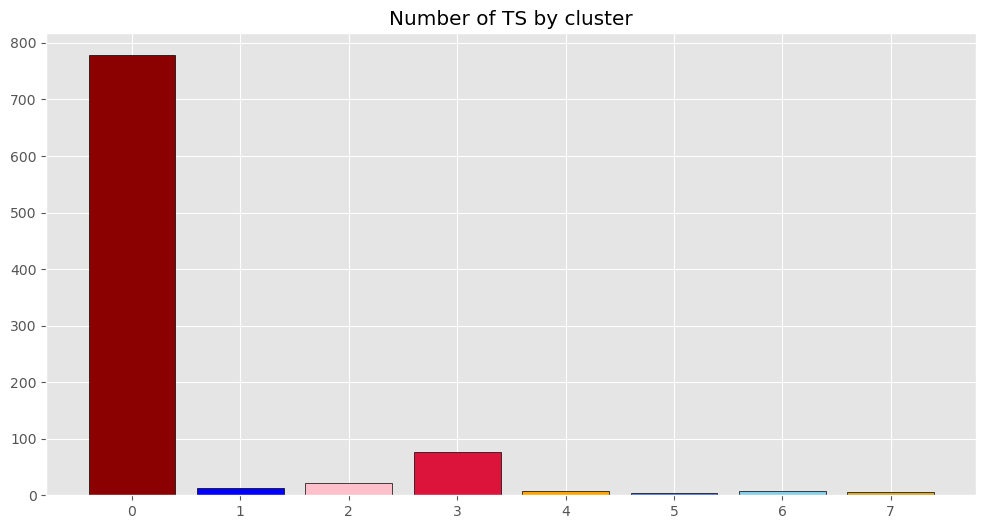


KMeans inertia:  1034.9874782512825



In [34]:
# centroids
centroids_sax = kmeans_sax.cluster_centers_
print('Centroids\' shape',centroids_sax.shape)
print()

# inverse transform
#df_centroids_sax = dft_inverse_trasform(np.squeeze(centroids_sax), n_coefs=centroids_sax.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_sax)):
#    c = np.array(df_centroids_sax[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_sax = kmeans_sax.labels_
print('KMeans assigned labels:\n',km_labels_sax)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_sax, return_counts=True)[0], np.unique(km_labels_sax, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_sax = kmeans_sax.inertia_
print('KMeans inertia: ', inertia_sax)
print()

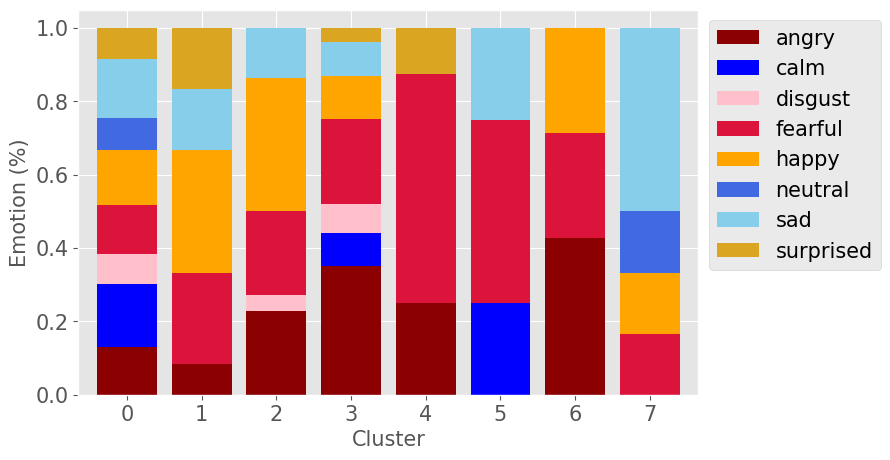



Adjusted_mutual_info_score = 0.027
Adjusted_rand_score = -0.003
Fowlkes_mallows_score = 0.311
Silhouette_score = 0.398


In [35]:
# emotions' distribution within different clusters and evaluation measures
res_km_sax = plot_eval_clust(km_labels_sax, y_clust_sax, X_clust_sax, 'km_sax')
results['km_sax'] = res_km_sax

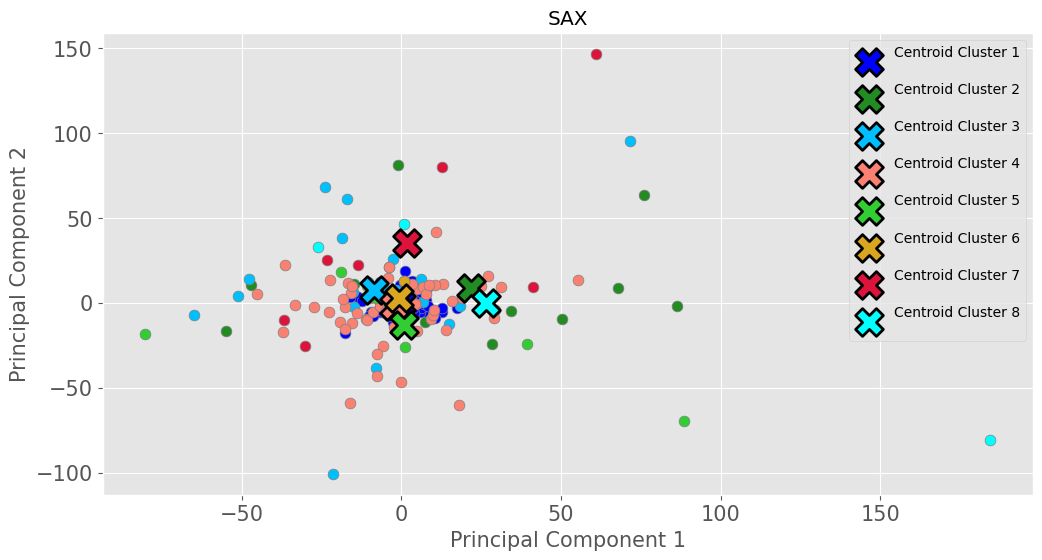

In [36]:
plot_pca_clust(X_clust_sax,km_labels_sax,name='sax')

### PAA

In [37]:
X_clust_paa, y_clust_paa, df_paa = imp_data('data_ts\data_150_paa.csv', 'data_ts\\ts_150_paa.npy', fraction = fraction, emotions = n_clusters)
print(df_paa.shape)
df_paa.head()

(914, 151)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,3,-0.009181,-0.016150,-0.016126,-0.014893,-0.008963,0.011608,0.003789,0.003940,0.016012,0.023392,-0.060181,-0.003097,0.002169,0.016444,0.005731,-0.000677,0.059279,0.048124,0.040465,-0.018534,-0.100695,-0.127685,-0.102069,-0.084384,-0.022782,0.071309,0.059959,0.005776,0.022119,0.062967,0.075870,0.017583,-0.017181,-0.071922,-0.076734,0.032331,0.128760,0.113043,0.180157,0.137507,-0.470873,-0.380577,-0.026346,0.392899,0.401951,0.076984,0.136498,-0.108442,-0.090416,-0.118262,-0.011479,-0.189899,-0.282588,-0.090958,0.154127,-0.043037,-0.014728,0.015821,0.275675,0.294562,-0.444604,-0.533831,0.035126,0.059061,0.400995,0.163534,0.263472,-0.161540,-0.042200,-0.032197,0.015243,-0.074993,-0.122540,-0.141110,0.030689,-0.104581,0.042415,-0.068658,1.182612,1.421571,-2.024449,-3.038951,1.294782,0.632665,0.064779,0.559874,0.559803,0.135136,-0.329484,-0.090836,0.042806,-0.005502,0.438894,0.391988,-0.120484,0.097992,-0.225734,-1.036428,-0.711586,0.295095,0.735590,0.195758,0.232458,0.093032,0.042720,-0.165544,-0.209217,-0.307417,-0.208058,0.022474,0.204634,0.132500,0.121670,0.039612,0.018398,-0.052672,-0.035303,0.048651,-0.029836,0.050040,0.158913,0.099126,-0.239710,-0.032043,0.218214,-0.008008,-0.465661,-0.765783,-0.606688,0.286101,0.438029,0.287226,0.696031,0.506319,0.120113,-0.123157,-0.230482,-0.063030,-0.022609,-0.072083,0.011990,0.032853,-0.041041,-0.088678,-0.027405,-0.021444,-0.001591,0.070307,-0.028815,-0.143300
1,7,-0.001226,0.003587,-0.001840,-0.006128,-0.065937,0.054373,0.057225,-0.051017,0.057126,-0.072129,0.042344,-0.054929,0.033545,0.048677,-0.083447,0.003692,0.103703,-0.014005,-0.055098,-0.031844,0.031112,0.001051,0.002603,-0.004638,-0.003317,0.011613,-0.004529,0.004937,0.002986,-0.002536,-0.000582,-0.001844,-0.001219,-0.049509,0.113021,-0.112813,0.109863,-0.042049,0.044627,-0.015676,-0.058667,0.022579,-0.031786,0.016330,-0.003636,0.017072,-0.001356,0.000200,-0.004233,-0.004186,-0.003088,-0.000082,0.000492,0.001250,0.000918,-0.001178,-0.000510,-0.000039,0.000337,0.001037,-0.002014,0.000121,-0.000002,0.015023,0.040977,-0.006506,-0.045935,-0.000467,0.004655,-0.019910,-0.002744,0.043379,-0.052195,0.085761,-0.050011,-0.069135,0.154545,-0.166782,-0.040828,0.066081,0.150639,0.084706,-0.315889,0.169248,-0.071131,0.094795,-0.011370,-0.015836,-0.050227,-0.060868,0.047199,0.079275,0.007388,-0.079043,0.005166,0.012579,-0.036428,0.025076,0.004922,0.021061,-0.028528,0.085053,-0.073105,0.050316,-0.089959,0.116045,-0.112405,0.017558,0.007596,0.016327,-0.009240,0.016603,-0.019818,0.013902,-0.014535,0.005640,0.029397,-0.043229,0.042032,-0.030605,0.025870,-0.003240,-0.097644,0.085211,0.034570,-0.036808,0.061845,-0.060060,-0.083276,-0.005635,0.066253,0.091865,-0.047010,0.003694,-0.023523,0.025376,-0.035490,0.016282,-0.032863,-0.029694,0.059571,-0.065849,0.102110,0.000797,-0.084646,0.033873,0.004640,-0.005309,-0.000410,0.003950
2,3,0.000705,0.000728,-0.000534,0.000760,0.000117,0.000208,0.000548,0.000024,0.000048,-0.004080,0.003529,-0.001058,0.000312,-0.001539,0.001127,0.025558,0.025793,-0.060876,0.026410,0.005488,-0.065471,-0.005250,0.069994,0.043882,-0.077197,-0.020767,0.036196,0.009938,-0.039228,0.049776,-0.004776,-0.033909,-0.007320,0.081041,-0.052247,-0.050109,0.098424,-0.084547,0.050821,-0.042658,0.045389,-0.009888,-0.064509,0.058262,0.019916,-0.025032,0.001978,-0.002820,0.000457,-0.001738,-0.003935,0.001851,-0.000811,0.003331,-0.014817,-0.009172,0.035593,0.023997,-0.002839,-0.034767,-0.039047,0.013955,0.014893,0.013075,-0.007464,0.005100,0.002026,-0.002

In [38]:
print('____________________PAA____________________')
print()

# computing kMeans
kmeans_paa = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=5, init='k-means++', random_state=100, max_iter_barycenter=5)
kmeans_paa.fit(X_clust_paa)

____________________PAA____________________



TimeSeriesKMeans(max_iter=5, max_iter_barycenter=5, metric='dtw', n_clusters=8,
                 random_state=100)

Centroids' shape (8, 150, 1)

KMeans assigned labels:
 [6 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 2 0 0 2 0 0 0 0 0 0 0 5 4 2 0 0 0 0 6 4 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 2 0 0 0 0 0 0 5 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 5 0 0 0 0 0 2 0 0 0 0 0 0 0
 2 0 2 0 0 0 0 6 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 6 0 7 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 7 0 0 0 0 0 2 2 0 0 0 0 0 0 0
 4 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 0 0 4 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 5 0 0 0 0 0 0 2 0 0 0 4 0
 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0 0 0 6 0 0 4 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 4 2 0 4 0 0 7 0 0 0 0 0 0
 6 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 

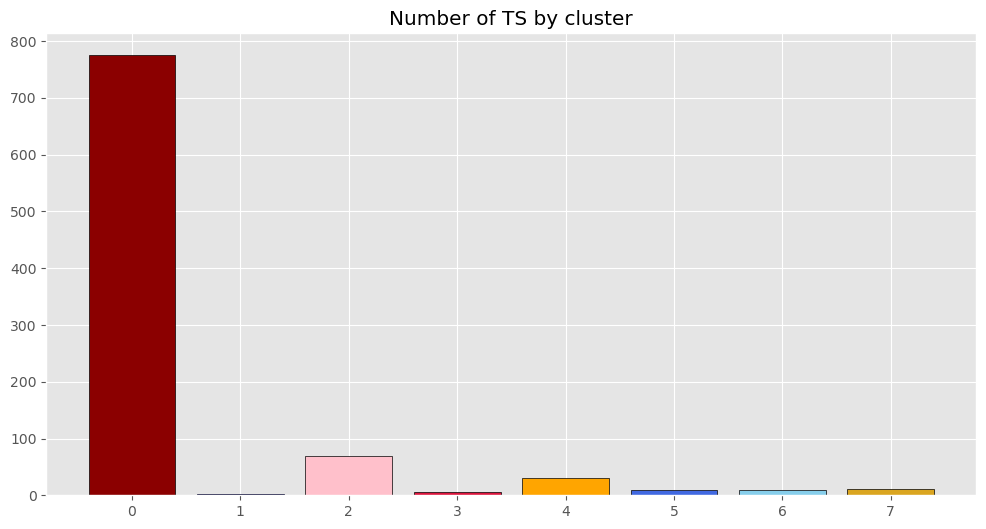


KMeans inertia:  1.0650312127104036



In [39]:
# centroids
centroids_paa = kmeans_paa.cluster_centers_
print('Centroids\' shape',centroids_paa.shape)
print()

# inverse transform
#df_centroids_paa = dft_inverse_trasform(np.squeeze(centroids_paa), n_coefs=centroids_paa.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_paa)):
#    c = np.array(df_centroids_paa[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_paa = kmeans_paa.labels_
print('KMeans assigned labels:\n',km_labels_paa)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_paa, return_counts=True)[0], np.unique(km_labels_paa, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_paa = kmeans_paa.inertia_
print('KMeans inertia: ', inertia_paa)
print()

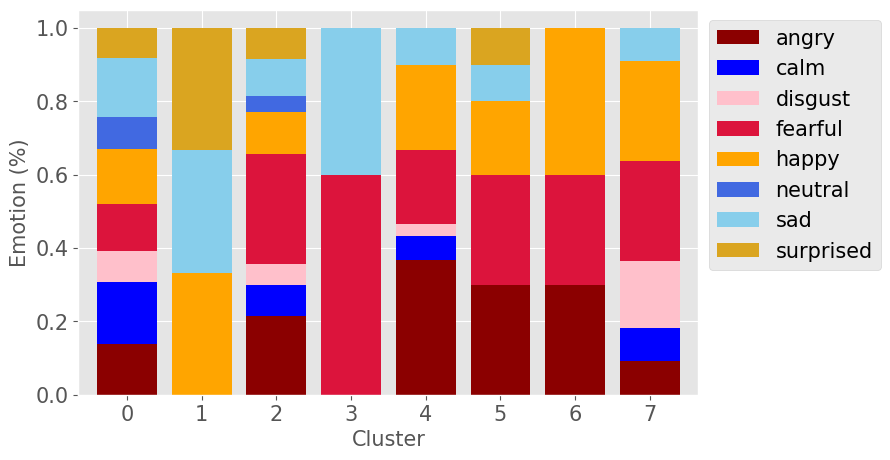



Adjusted_mutual_info_score = 0.016
Adjusted_rand_score = -0.003
Fowlkes_mallows_score = 0.31
Silhouette_score = 0.426


In [40]:
# emotions' distribution within different clusters and evaluation measures
res_km_paa = plot_eval_clust(km_labels_paa, y_clust_paa, X_clust_paa, 'km_paa')
results['km_paa'] = res_km_paa

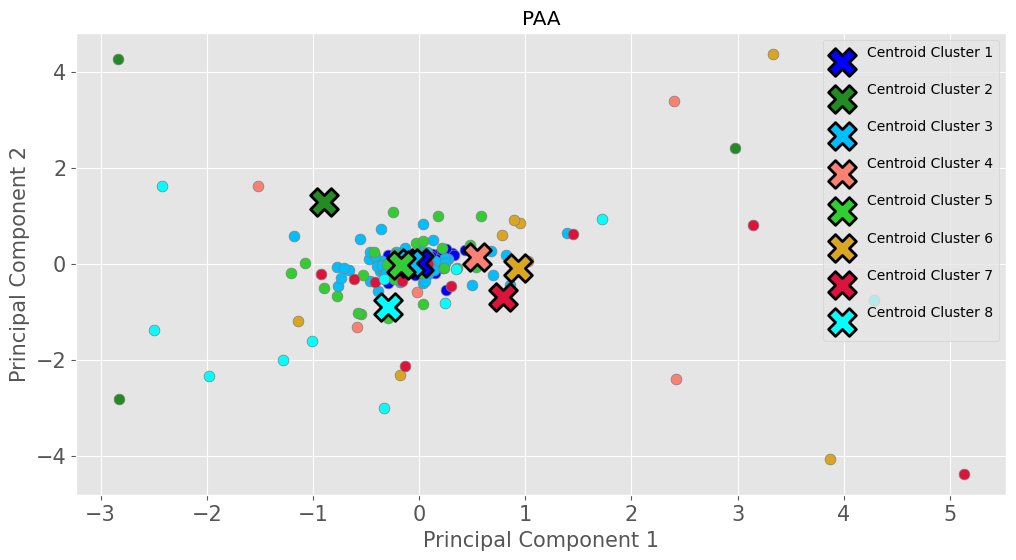

In [41]:
plot_pca_clust(X_clust_paa,km_labels_paa,'paa')

### DFT

In [42]:
X_clust_dft, y_clust_dft, df_dft = imp_data('data_ts\data_150_dft.csv', 'data_ts\\ts_150_dft.npy', fraction = fraction, emotions = n_clusters)
print(df_dft.shape)
df_dft.head()

(914, 151)


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,3,-3.552714e-15,-1.244801,4.281954,-0.807810,-1.163216,-5.545275,23.628888,-10.409080,6.678316,-1.730009,-12.666532,-71.053544,-1.772132,20.480025,-65.292471,1.850320,-7.209136,42.941550,-24.255274,103.791756,87.141946,-71.197834,30.981585,-8.139965,-5.438237,-67.760147,75.235760,-56.344621,-122.097086,-86.767906,-38.037998,231.438911,-27.863325,-46.912892,106.896371,27.118223,-130.751561,58.435291,214.933950,-157.573024,-34.708521,94.151342,-25.050411,-201.857656,-42.076550,137.379564,23.580357,-32.017678,-44.590714,109.151165,16.459915,-162.706731,44.517936,97.419009,-55.915444,-59.532145,80.900149,-18.173337,-174.347044,47.813603,152.579586,34.516521,-96.145958,-62.025211,132.155461,-59.598348,-134.853651,64.648671,113.113245,-115.529241,-153.163045,210.632514,19.877050,-173.815539,27.063151,185.278240,18.402829,-157.880975,32.713736,76.348999,-52.406240,-112.369171,79.476529,102.405841,-151.987112,-56.863429,160.146102,-39.819477,-199.258345,98.209790,175.288349,-88.198668,-119.723271,95.469286,66.840337,-112.957049,-19.830752,82.054535,-1.517874,-93.084989,-23.726990,107.662426,-48.326756,-73.792066,53.502599,106.452107,-47.970574,-58.669040,84.580349,3.327019,-65.871774,-7.396592,61.484007,-29.438510,-69.667826,36.699197,30.910332,-30.300942,-53.891560,59.865422,45.044396,-45.776898,-22.305228,42.857097,6.487027,-40.004937,24.564832,19.926309,-38.047790,-13.596297,33.830259,1.061156,-41.372031,9.345972,25.072535,-1.921036,-23.028645,15.938602,14.161302,-18.562355,1.786729,17.496918,-3.629578,-24.825106,8.696473,16.128464,-26.376766,-1.404140,23.433830,-13.844991
1,7,2.486900e-14,-0.086931,0.001168,0.019269,-0.111728,-0.154932,-0.175524,0.149490,-0.013097,0.057148,-0.061236,-0.160364,0.043080,-0.006654,-0.006218,-0.039257,-0.003458,-0.117480,-0.029184,0.140665,-0.004047,-0.265123,-0.034318,0.033966,0.270719,-0.043717,-0.057609,0.033723,-0.393054,-0.573894,0.041198,0.497978,0.631271,0.480242,-0.564272,-0.340959,-0.105818,-0.463398,0.266421,0.253989,0.176766,0.111958,-0.367461,-0.246232,-0.210274,0.290113,0.274498,-0.155398,0.059344,-0.234080,-0.265799,0.230490,-0.116034,0.158155,0.138759,-0.269824,-0.050520,-0.252952,-0.155495,0.062679,-0.061722,-0.161332,-0.528913,-0.370408,-0.569472,0.431607,-0.211382,0.591574,0.194822,-0.081482,0.033409,-0.376848,-0.073913,0.016296,0.012084,0.133144,-0.145600,-0.141037,-0.136452,0.107071,0.074344,0.048903,0.144023,0.350732,-0.039818,-0.243014,0.303438,-0.367956,0.008260,-0.135122,-0.119798,-0.031984,-0.184532,-0.105826,0.258917,-0.223803,-0.166749,0.290299,0.137587,-0.143522,0.165928,-0.051241,0.509289,-0.285762,-0.293787,-0.059770,-0.502268,0.366687,-0.115740,-0.081989,1.183692,-0.494321,0.011307,0.072915,-0.193084,0.508300,-0.044178,-0.191730,0.540129,-0.215532,-0.078008,0.152984,-0.367488,0.371348,0.144235,0.740634,0.806800,-0.429511,0.468597,-1.338867,0.735900,-0.224072,-1.159643,0.152808,-0.513081,0.542017,0.578501,-0.487986,0.263743,0.405479,-0.712981,-0.263647,0.706281,-0.305190,0.449715,-0.646446,-0.655424,0.301265,0.847290,0.487739
2,3,2.753353e-14,0.001319,-0.014132,0.020050,-0.048667,-0.012637,-0.001244,-0.068451,-0.015282,0.129840,0.014548,-0.025528,-0.016966,0.008186,-0.008028,0.068521,-0.039699,-0.196818,0.012568,-0.046555,-0.138825,0.070894,-0.118412,-0.070379,-0.042024,-0.000923,0.029197,-0.055185,-0.087135,-0.100245,-0.152741,-0.155264,-0.028146,0.079822,0.360393,0.352865,-0.263294,0.082526,0.230862,-0.187007,0.070421,0.364953,-0.575951,-0.157103,-0.033795,-0.453600,-0.067945,0.

In [43]:
print('____________________DFT____________________')
print()

# computing kMeans
kmeans_dft = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, #dtw, softdtw
                      max_iter=5, init='k-means++', random_state=100, max_iter_barycenter=5)
kmeans_dft.fit(X_clust_dft)

____________________DFT____________________



TimeSeriesKMeans(max_iter=5, max_iter_barycenter=5, metric='dtw', n_clusters=8,
                 random_state=100)

Centroids' shape (8, 150, 1)

KMeans assigned labels:
 [6 0 0 0 0 4 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 1 4 0 0 0 0 3 3 4 0 0 4 0 0 0 0 0 0 6 0 0 0
 4 0 0 0 0 0 4 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0 4 5 0 0 4 0 0 4 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 6 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 4 0 2 0 3 0 4 0 0 0 0 0 0 0 5 0 0 0 0 4 0 4 4 4 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 0 0 0 0 0 4 4 0 0 0 0 0 0 0
 6 0 0 1 0 0 0 0 0 0 0 4 0 0 4 0 0 0 6 0 0 0 0 0 0 0 7 0 0 0 4 0 0 0 0 4 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 4
 4 0 4 0 0 4 0 0 1 0 0 4 0 0 0 0 0 4 4 0 0 0 0 4 5 0 0 4 0 0 0 4 0 0 0 1 0
 0 0 0 4 0 0 0 0 4 6 0 0 0 0 0 0 4 0 0 0 4 4 0 0 0 0 4 0 0 0 0 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 4 0 0 1 0 0 0 0 0 0
 0 4 0 0 0 0 0 4 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 6 4 0 1 0 0 5 0 0 0 0 0 4
 6 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 0 

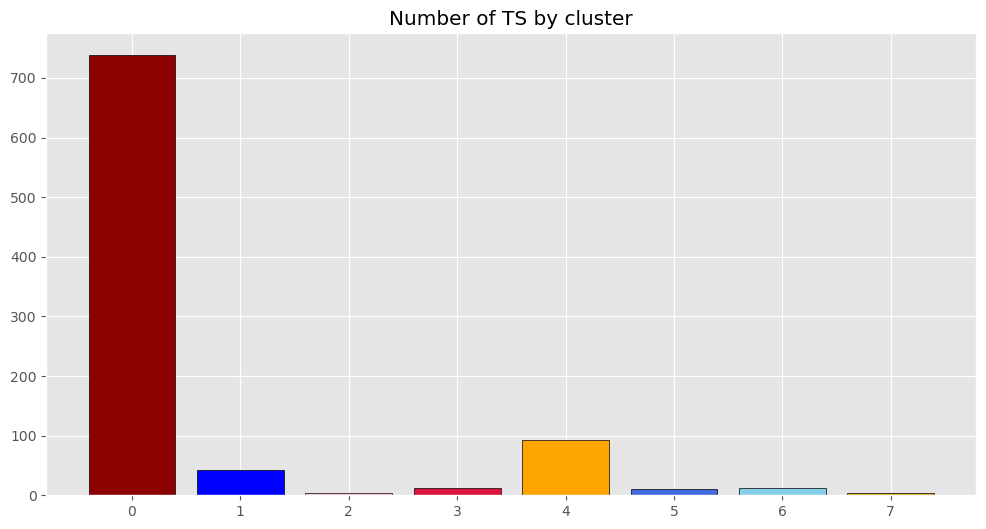


KMeans inertia:  29283.097782962024



In [44]:
# centroids
centroids_dft = kmeans_dft.cluster_centers_
print('Centroids\' shape',centroids_dft.shape)
print()

# inverse transform
#df_centroids_dft = dft_inverse_trasform(np.squeeze(centroids_dft), n_coefs=centroids_dft.shape[1], n_timestamps=len(Xdf.columns))

# plotting the centroids (disalligned)
#for i in range(len(df_centroids_dft)):
#    c = np.array(df_centroids_dft[i])+ i*0.07
#    plt.plot(np.squeeze(c))
#plt.tick_params(left = False, labelleft = False)
#plt.title('Clusters\' centroids')
#plt.show()

# extracting the labels
km_labels_dft = kmeans_dft.labels_
print('KMeans assigned labels:\n',km_labels_dft)
print()

# n of time series belonging to each cluster
plt.bar(np.unique(km_labels_dft, return_counts=True)[0], np.unique(km_labels_dft, return_counts=True)[1], color = ['darkred','blue','pink','crimson','orange','royalblue','skyblue','goldenrod'], edgecolor = 'k')
plt.title('Number of TS by cluster')
plt.show()
print()

inertia_dft = kmeans_dft.inertia_
print('KMeans inertia: ', inertia_dft)
print()

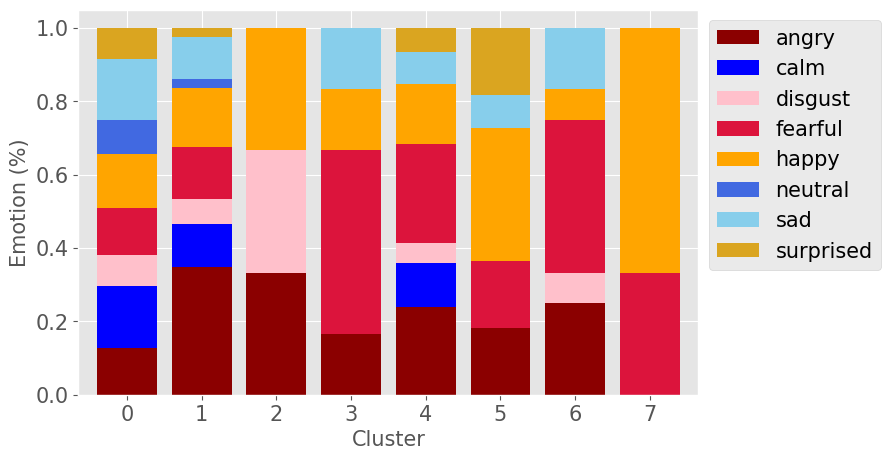



Adjusted_mutual_info_score = 0.021
Adjusted_rand_score = -0.004
Fowlkes_mallows_score = 0.295
Silhouette_score = 0.59


In [45]:
# emotions' distribution within different clusters and evaluation measures
res_km_dft = plot_eval_clust(km_labels_dft, y_clust_dft, X_clust_dft, 'km_dft')
results['km_dft'] = res_km_dft

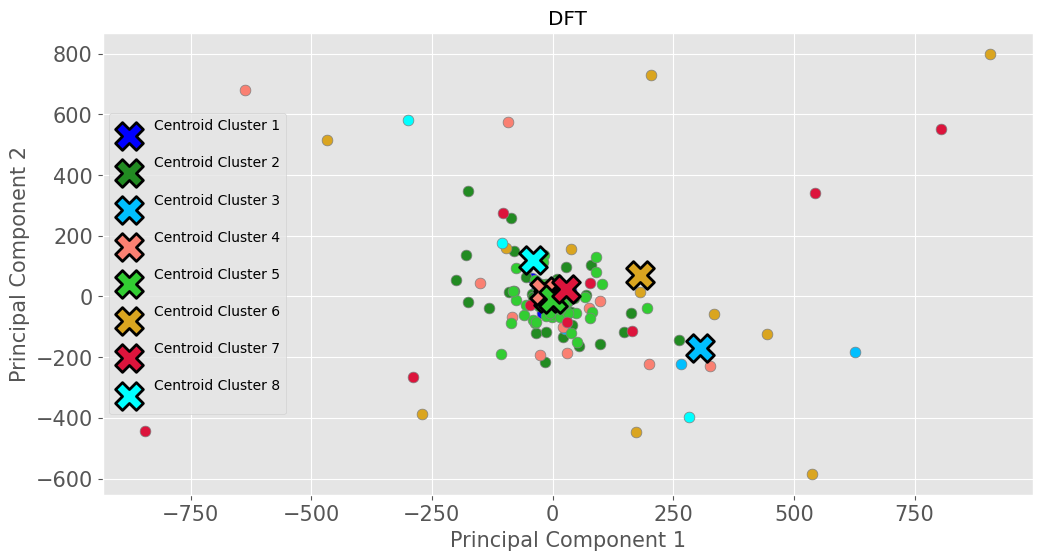

In [46]:
plot_pca_clust(X_clust_dft,km_labels_dft,'dft')

In [47]:
print('DTW')
pd.DataFrame(results.values()).T

DTW


,0,1,2
adjusted_mutual_info_score_KM_SAX,0.027135,NaN,NaN
adjusted_rand_score_KM_SAX,-0.003124,NaN,NaN
fowlkes_mallows_score_KM_SAX,0.310669,NaN,NaN
silhouette_score_KM_SAX,0.397970,NaN,NaN
adjusted_mutual_info_score_KM_PAA,NaN,0.016279,NaN
adjusted_rand_score_KM_PAA,NaN,-0.002959,NaN
fowlkes_mallows_score_KM_PAA,NaN,0.309507,NaN
silhouette_score_KM_PAA,NaN,0.426373,NaN
adjusted_mutual_info_score_KM_DFT,NaN,NaN,0.021265
adjusted_rand_score_KM_DFT,NaN,NaN,-0.003646


#### DFT is the best...

## Hierarchical Clustering

- For the COMPLETE method, we used as distance DTW
- For the WARD method we could only use EUCLIDEAN metric

In [48]:
results['km_dft'].values()

dict_values([0.02126477236635599, -0.0036458870154555574, 0.2953201737116185, 0.5899528655768249])

### SAX

In [49]:
d_sax, d_mat_sax = dtw_and_matrix(X_clust_sax)

### Complete Linkage

Cophenetic Coefficient: 0.9214772101118658


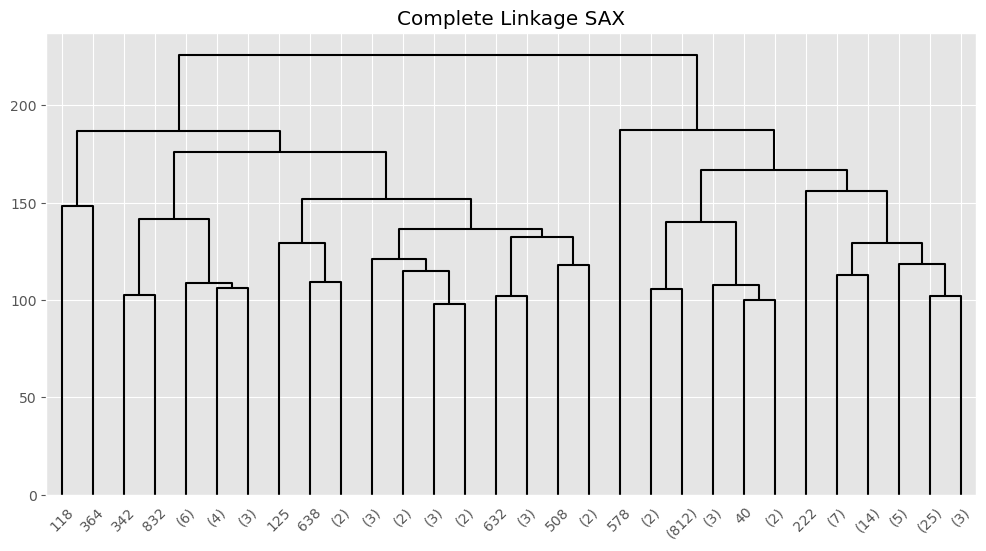

In [50]:
plot_dendr(d_sax,'sax','complete',color_threshold = 8)

### Ward's method

Cophenetic Coefficient: 0.8667346582612369


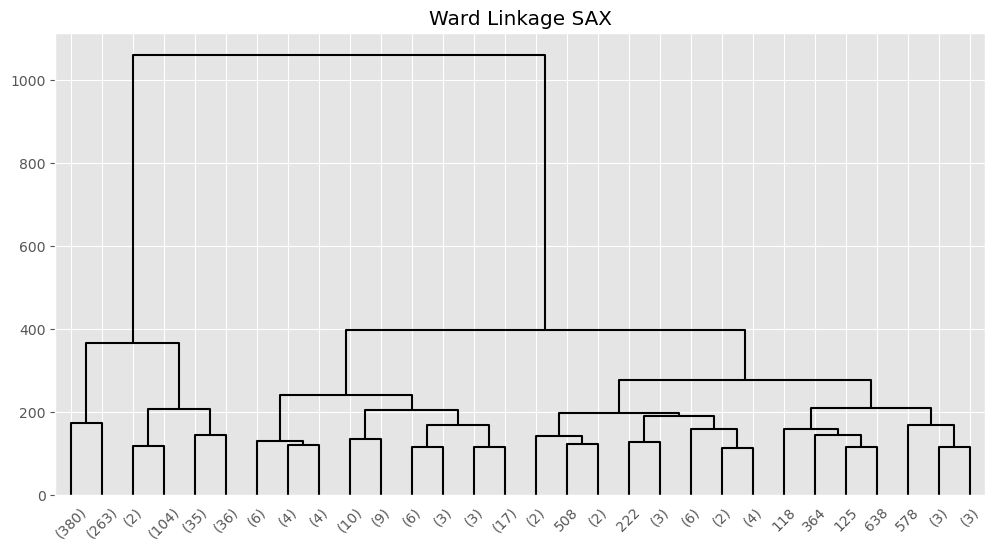

In [51]:
plot_dendr(d_sax,'sax','ward',color_threshold=23)

2    820
3     54
4     17
1     15
7      4
0      2
6      1
5      1
dtype: int64


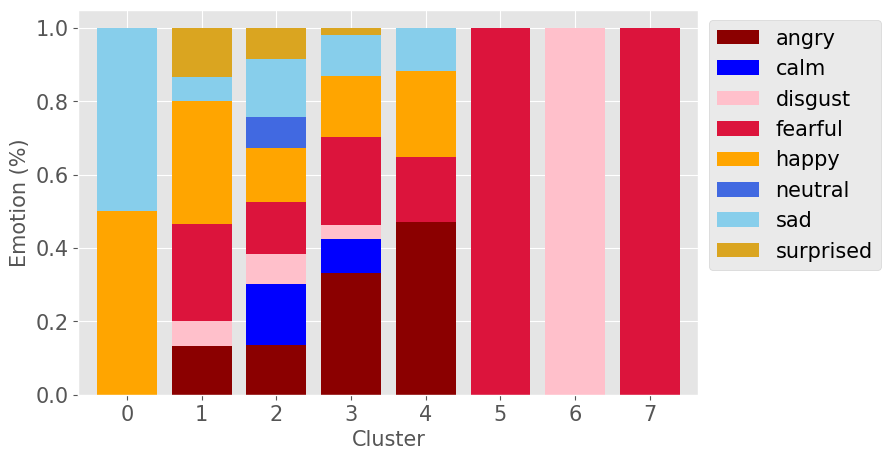



Adjusted_mutual_info_score = 0.022
Adjusted_rand_score = -0.004
Fowlkes_mallows_score = 0.326
Silhouette_score = 0.477


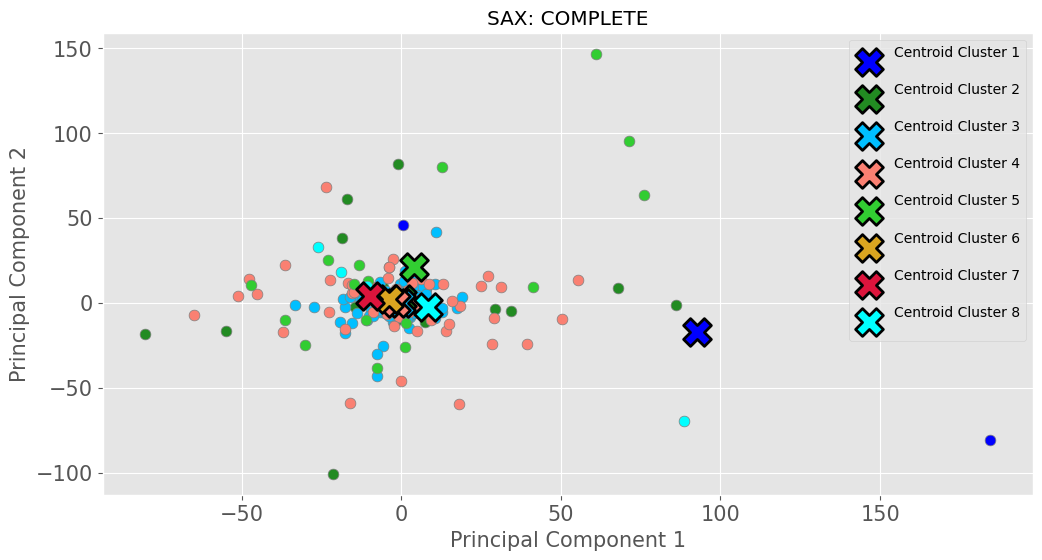

2    879
4     11
6      6
3      5
0      5
5      5
1      2
7      1
dtype: int64


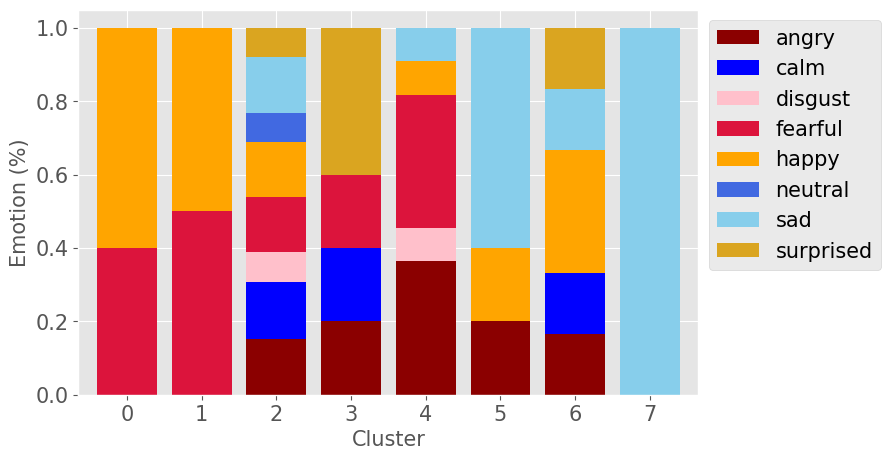



Adjusted_mutual_info_score = 0.003
Adjusted_rand_score = -0.002
Fowlkes_mallows_score = 0.351
Silhouette_score = 0.54


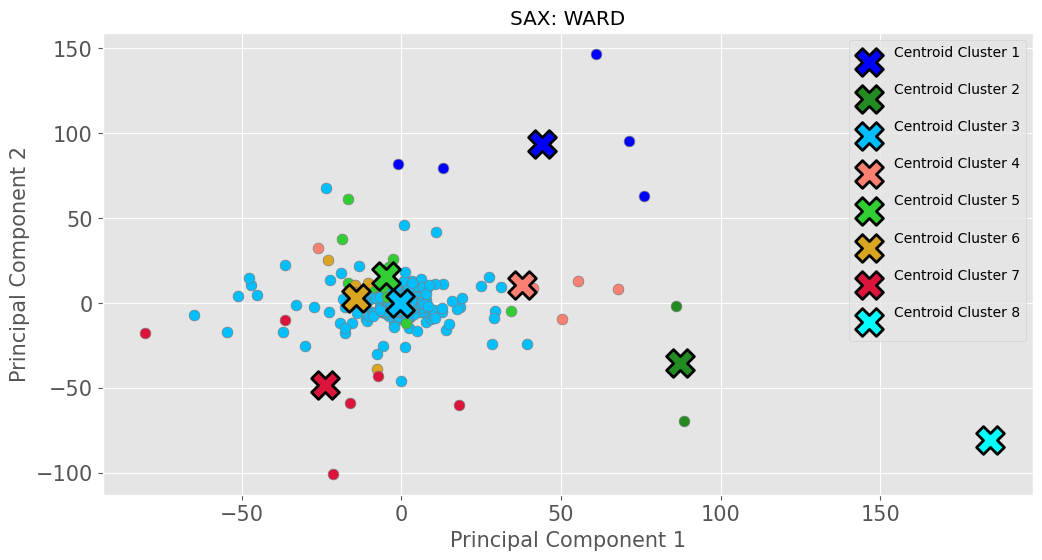

In [52]:
# clustering
data = [d_mat_sax, X_clust_sax]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, y_clust_sax, X_clust_sax)
    plot_pca_clust(X_clust_sax, labels, f'sax: {l}')
#plot_pca_clust(X_clust_sax, y_clust_sax, 'original')

### PAA

In [53]:
d_paa, d_mat_paa = dtw_and_matrix(X_clust_paa)

### Complete Linkage

Cophenetic Coefficient: 0.9524499967896746


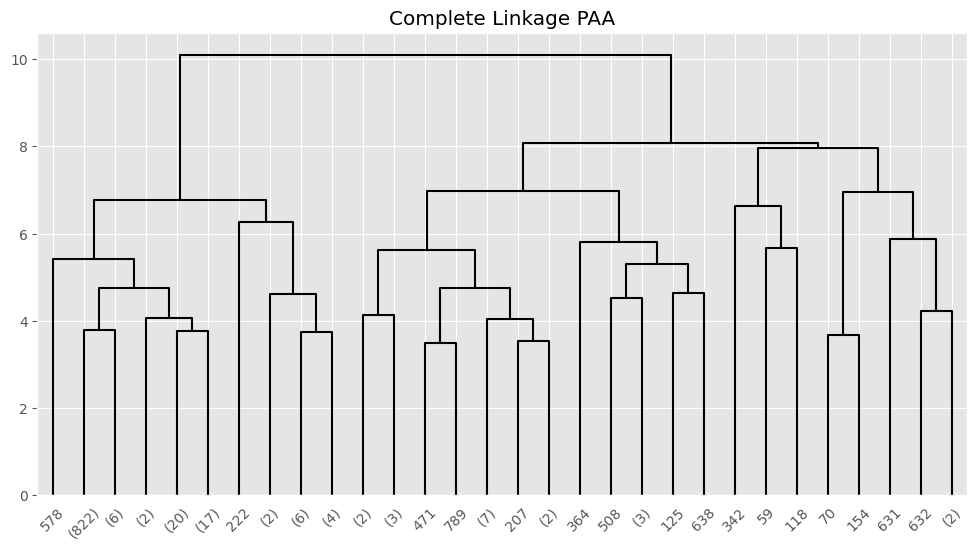

In [54]:
plot_dendr(d_paa,'paa','complete',color_threshold=2.1)

### Ward's method

Cophenetic Coefficient: 0.8376287171925098


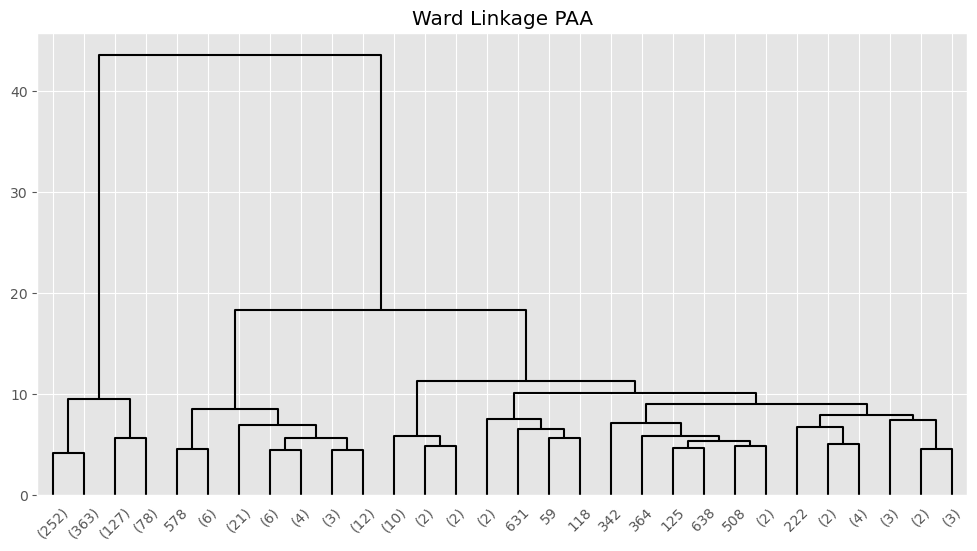

In [55]:
plot_dendr(d_paa,'paa','ward',color_threshold=3.5)

6    868
4     17
0     13
2      7
1      4
3      2
5      2
7      1
dtype: int64


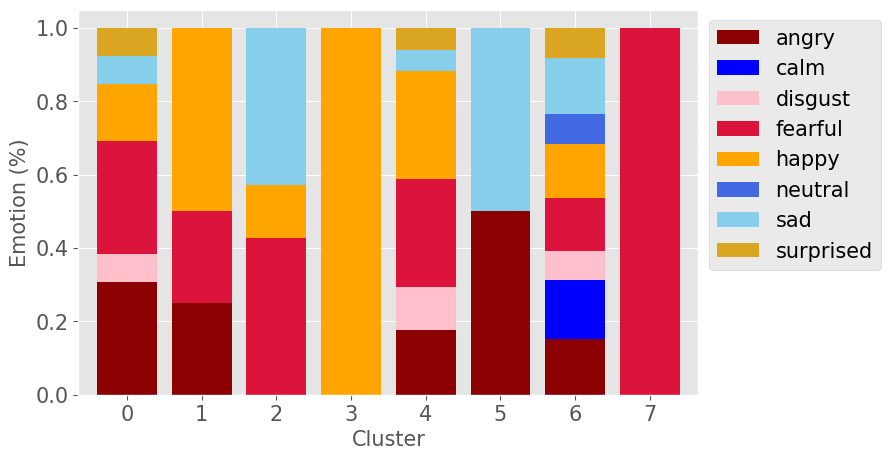



Adjusted_mutual_info_score = 0.006
Adjusted_rand_score = -0.002
Fowlkes_mallows_score = 0.346
Silhouette_score = 0.667


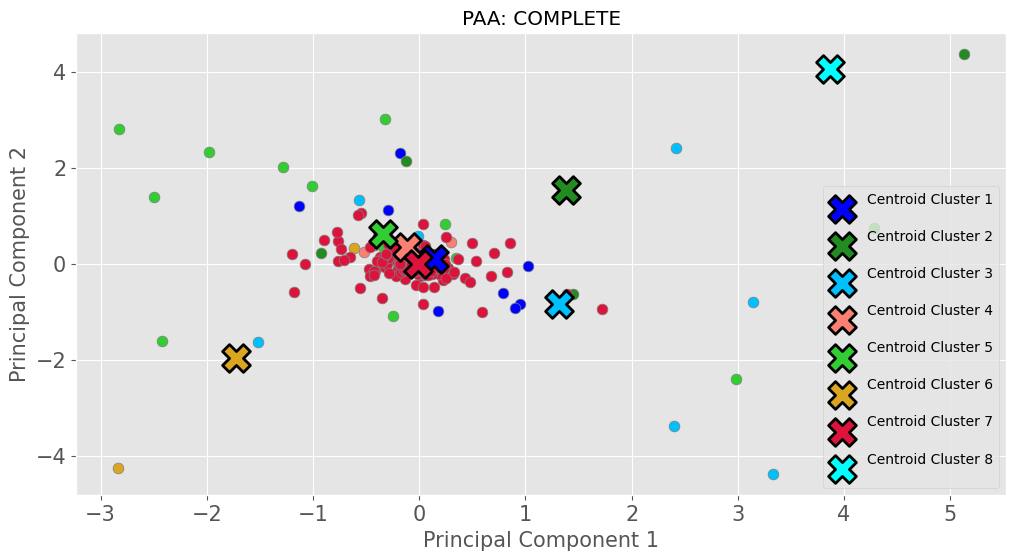

2    892
0      5
3      5
4      4
1      3
7      3
5      1
6      1
dtype: int64


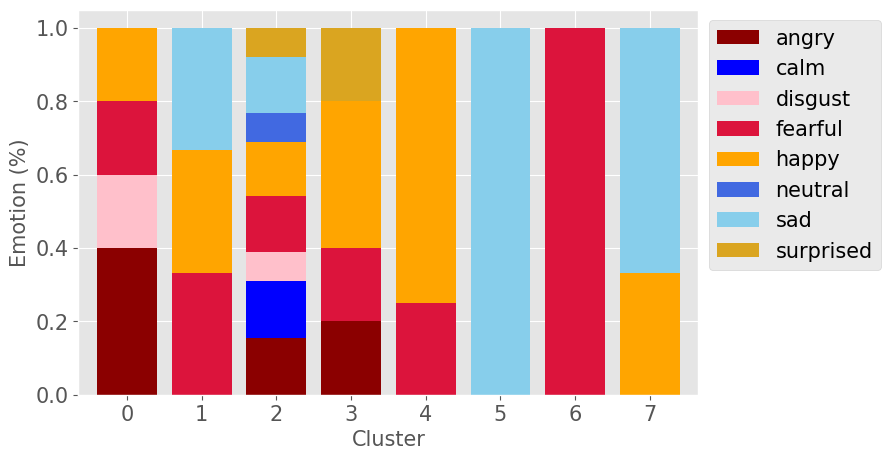



Adjusted_mutual_info_score = -0.0
Adjusted_rand_score = -0.001
Fowlkes_mallows_score = 0.357
Silhouette_score = 0.697


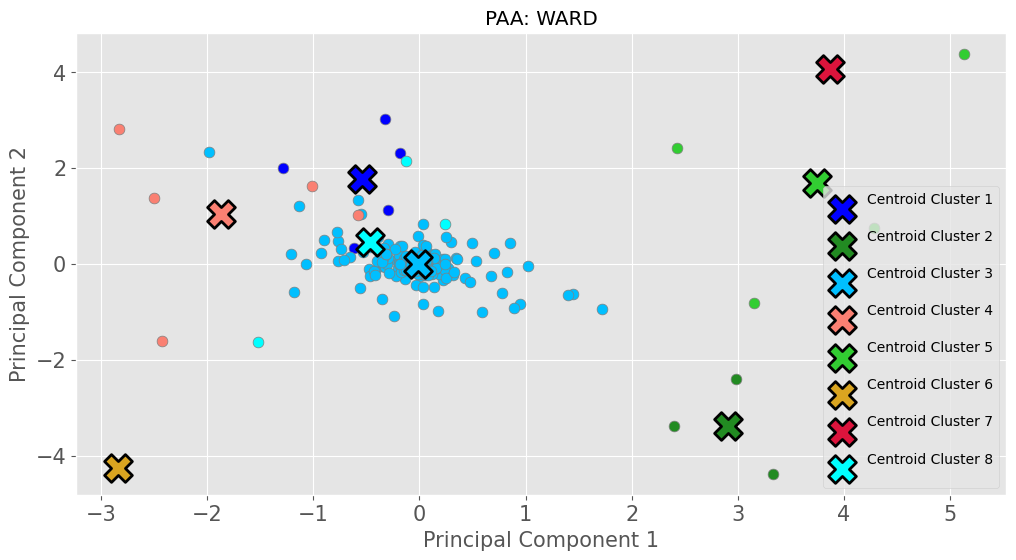

In [56]:
# clustering
data = [d_mat_paa, X_clust_paa]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, y_clust_paa, X_clust_paa)
    plot_pca_clust(X_clust_paa, labels, f'paa: {l}')
#plot_pca_clust(X_clust_paa, y_clust_paa, 'original')

### DFT

In [57]:
d_dft, d_mat_dft = dtw_and_matrix(X_clust_dft)

### Complete Linkage

Cophenetic Coefficient: 0.9575113461672408


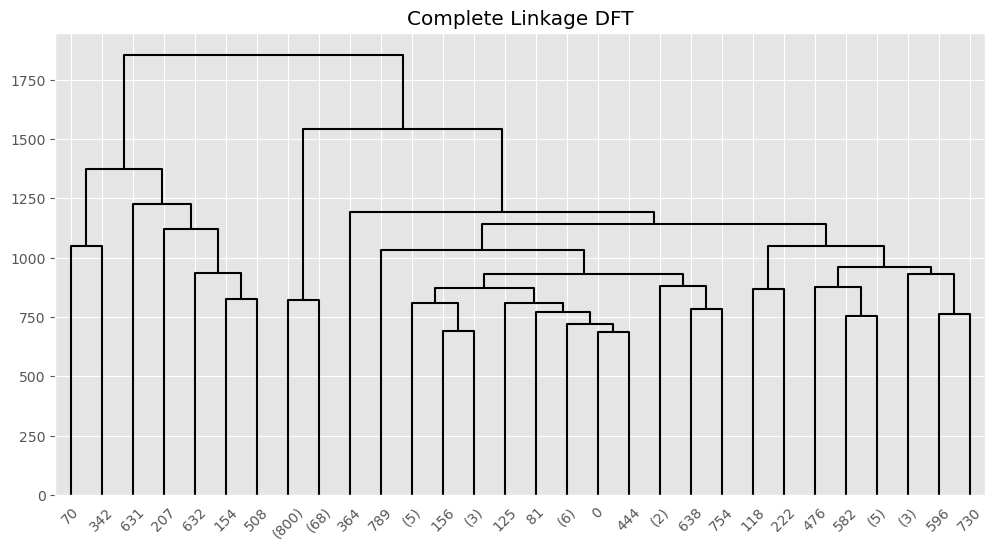

In [58]:
plot_dendr(d_dft,'dft','complete',color_threshold=2.2)

### Ward's method

Cophenetic Coefficient: 0.8845488718755342


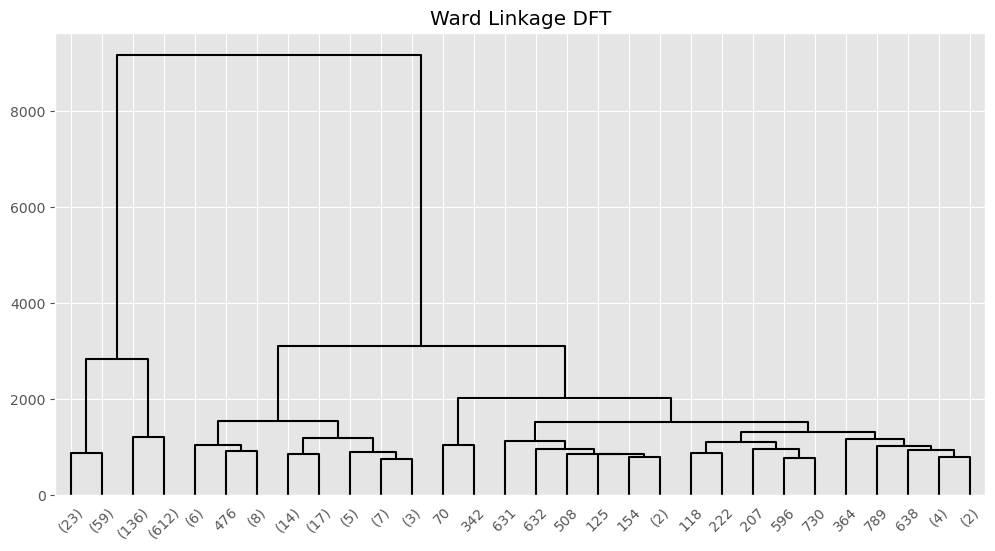

In [59]:
plot_dendr(d_dft,'dft','ward',color_threshold=4)

6    868
2     24
1     14
3      3
0      2
7      1
5      1
4      1
dtype: int64


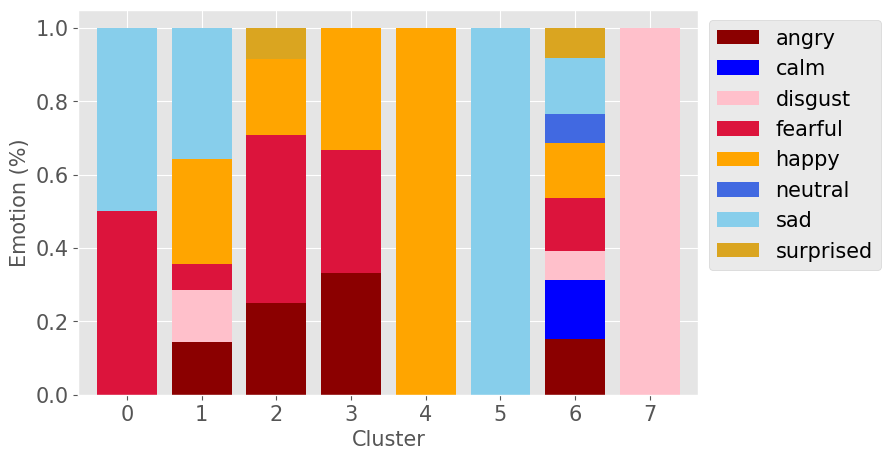



Adjusted_mutual_info_score = 0.014
Adjusted_rand_score = -0.002
Fowlkes_mallows_score = 0.347
Silhouette_score = 0.801


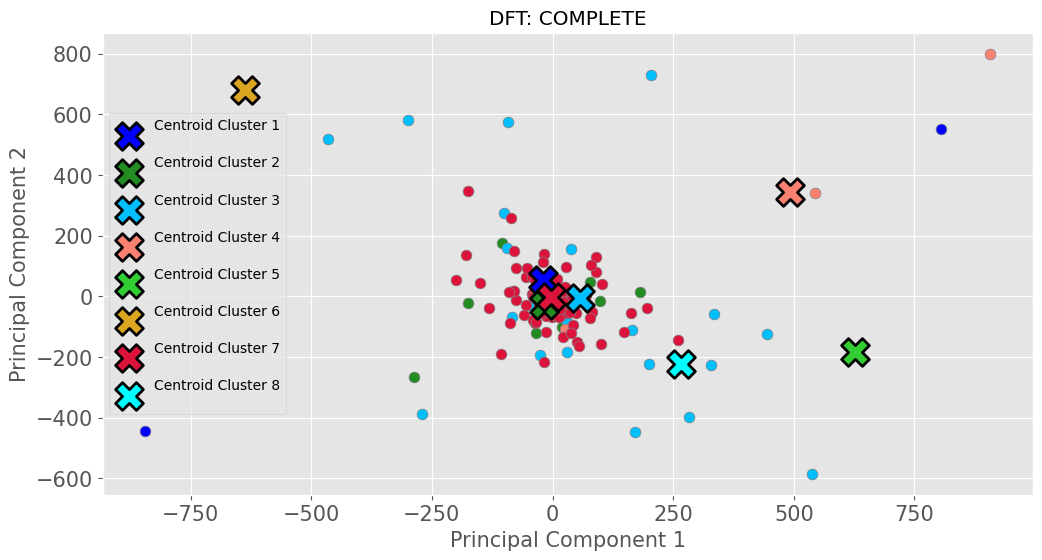

0    897
3      5
4      4
1      3
2      2
5      1
6      1
7      1
dtype: int64


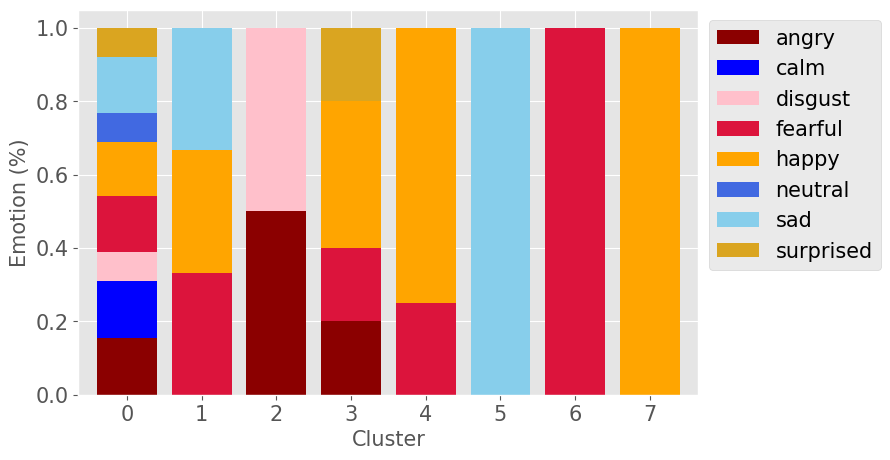



Adjusted_mutual_info_score = -0.0
Adjusted_rand_score = -0.001
Fowlkes_mallows_score = 0.359
Silhouette_score = 0.796


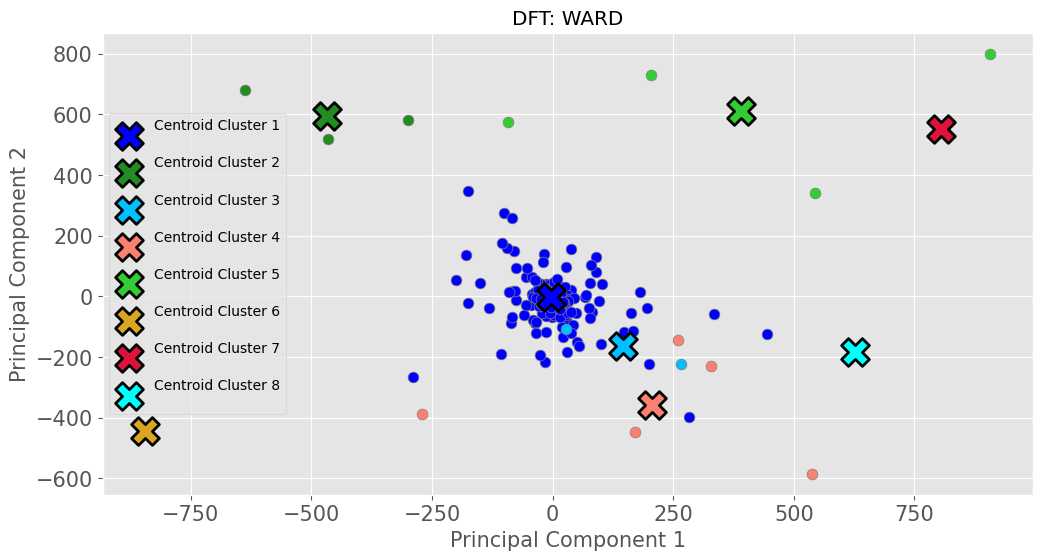

In [60]:
# clustering
data = [d_mat_dft, X_clust_dft]
affinity = ['precomputed','euclidean']
link = ['complete','ward']
for a,l,d in zip(affinity, link, data):
    agg = AgglomerativeClustering(n_clusters = n_clusters, metric = a, linkage = l)
    agg.fit(d)
    labels = agg.labels_
    print(pd.Series(labels).value_counts(), sep = ', ')
    plot_eval_clust(labels, y_clust_dft, X_clust_dft)
    plot_pca_clust(X_clust_dft, labels, f'dft: {l}')
#plot_pca_clust(X_clust_dft, y_clust_dft, 'original')